## CSC 555 Project 1
Elizabeth Thompson

Schelling Segregation Model

In [214]:
# import necessary packages

from mesa import Agent
from mesa import Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation
import random
from mesa.datacollection import DataCollector
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import NumberInput, Slider, Checkbox, Choice, StaticText
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns


## Experiment Setup

1. Set up Agent class
2. Set up Model class
3. Creat functions for visualizations to run on agent and model classes

Agent Class Setup: This class is used to set up our agents and how we will collect agent-based data.

In [215]:
# Define Manhattan Distance to be used later in Agent Class
def manhattan_distance(pos1, pos2):
    """Calculate the Manhattan distance between two points in a grid."""
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x1 - x2) + abs(y1 - y2)

# Define Agent Class
class SchellingAgent(Agent):
    """
    An agent with a type (Red or Blue), a subtype (Light, Pale, Dark) and a tolerance threshold (Light = 75%, Pale = 50, Dark = 25%).
    """
    def __init__(self, unique_id, model, agent_type, agent_subtype, tolerance_threshold):
        super().__init__(unique_id, model)
        self.agent_type = agent_type  # Red or Blue
        self.agent_subtype = agent_subtype # Light, Pale or Dark
        self.tolerance_threshold = tolerance_threshold  # (Light = 75%, Pale = 50, Dark = 25%)
        self.moves = 0 # Counter for the number of times the agent has moved
        self.diversity_type = None # Store this for later analysis
        self.diversity_subtype = None # Store this for later analysis
        self.moved_this_step = False # Store this for later analysis

    # Define functions we'll need for our relocation code
    def get_position_type(self):
        """Determine if the agent is in a corner, edge, or middle."""
        x, y = self.pos
        if (x == 0 and y == 0) or (x == 0 and y == self.model.grid.height - 1) or \
           (x == self.model.grid.width - 1 and y == 0) or (x == self.model.grid.width - 1 and y == self.model.grid.height - 1):
            return 'corner'
        elif x == 0 or y == 0 or x == self.model.grid.width - 1 or y == self.model.grid.height - 1:
            return 'edge'
        else:
            return 'middle'
        
    def step(self):
        # Check if agent should relocate based on Tolerance and Diversity
        if self.should_relocate():
            self.move() 
        self.position_type = self.get_position_type()

    def calculate_type_diversity(self):
        """
        Calculate the diversity of the agent based on its type (Red or Blue).
        """
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        if len(neighbors) == 0:
            return 0  # No neighbors means no diversity
        
        # Count how many neighbors are of a different type
        different_type_neighbors = sum(
            1 for neighbor in neighbors if neighbor.agent_type != self.agent_type
        )
        
        # Diversity is the fraction of neighbors of a different type
        diversity_type = different_type_neighbors / len(neighbors)
        return diversity_type
        
    def calculate_subtype_diversity(self):
        """
        Calculate the diversity of the agent based on its subtype (Light, Pale, Dark).
        """
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        if len(neighbors) == 0:
            return 0  # No neighbors means no diversity

        # Count how many neighbors are of a different subtype
        different_subtype_neighbors = sum(
            1 for neighbor in neighbors if neighbor.agent_subtype != self.agent_subtype
        )
        
        # Diversity is the fraction of neighbors of a different subtype
        diversity_subtype = different_subtype_neighbors / len(neighbors)
        return diversity_subtype


    def should_relocate(self):
        """
        Determines whether an agent should relocate based on if its Diversity > Tolerance.
        """
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        if len(neighbors) == 0:
            self.diversity_type = 0
            self.diversity_subtype = 0
            return False  # If no neighbors, there's no need to move.

        # Diversity based on agent type
        different_type_neighbors = sum(
            1 for neighbor in neighbors if neighbor.agent_type != self.agent_type
        )
        self.diversity_type = different_type_neighbors / len(neighbors)

        # Diversity based on agent subtype
        different_subtype_neighbors = sum(
            1 for neighbor in neighbors if neighbor.agent_subtype != self.agent_subtype
        )
        self.diversity_subtype = different_subtype_neighbors / len(neighbors)

        # Determine if the agent should relocate based on tolerance threshold
        diversity = self.diversity_type  # Assuming relocation decision is based on type diversity
        return diversity > self.tolerance_threshold

    
    def calculate_satisfaction(self, pos):
        """"
        Calculate how satisfied an agent is. 
        Satisfaction score = total number of similar subtypes of an agent in neighborhood/ total # agents in neighborhood
        """
        neighbors = self.model.grid.get_neighbors(pos, moore=True, include_center=False)
        if len(neighbors) == 0:
            return 1  # No neighbors = full satisfaction
        
        same_subtype_neighbors = sum(
            1 for neighbor in neighbors if neighbor.agent_subtype == self.agent_subtype
        )
        satisfaction_ratio = same_subtype_neighbors / len(neighbors)

        return satisfaction_ratio
    
    def move_random_if_no_lower_satisfaction(self, current_satisfaction):
        """
        Move to a random cell only if it doesn't reduce satisfaction.
        """
        empty_cells = list(self.model.grid.empties)
        if empty_cells:
            new_position = self.random.choice(empty_cells)
            new_satisfaction = self.calculate_satisfaction(new_position)
            if new_satisfaction >= current_satisfaction:
                self.model.grid.move_agent(self, new_position)
                self.moves += 1
                self.moved_this_step = True


    # How our agents decide to move
    def move(self):
        """
        Move the agent based on the selected relocation strategy.
        """
        current_satisfaction = self.calculate_satisfaction(self.pos)

        if self.model.relocation_strategy == 'random':
            # Move to any empty cell in the Matrix
            empty_cells = list(self.model.grid.empties)
            if empty_cells:
                new_position = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, new_position)
                self.moves += 1
                self.moved_this_step = True


        elif self.model.relocation_strategy == 'random_higher_satisfaction':
            # Move to a random cell with higher satisfaction
            empty_cells = list(self.model.grid.empties)
            better_cells = [
                cell for cell in empty_cells if self.calculate_satisfaction(cell) > current_satisfaction
            ]

            if better_cells:
                new_position = self.random.choice(better_cells)
                self.model.grid.move_agent(self, new_position)
                self.moves += 1
                self.moved_this_step = True 

            else:
                # Revert to random relocation if no better satisfaction is found
                # But only move if it doesn't reduce satisfaction
                self.move_random_if_no_lower_satisfaction(current_satisfaction)
    
        elif self.model.relocation_strategy == 'nearest_higher_satisfaction':
            # Try to move to the nearest cell with higher satisfaction
            empty_cells = list(self.model.grid.empties)
            better_cells = [
                cell for cell in empty_cells if self.calculate_satisfaction(cell) > current_satisfaction
            ]
            
            if better_cells:
                # Find the nearest better cell
                distances = [
                    (manhattan_distance(self.pos, cell), cell) for cell in better_cells
                ]
                _, nearest_better_cell = min(distances, key=lambda x: x[0])
                self.model.grid.move_agent(self, nearest_better_cell)
                self.moves += 1
                self.moved_this_step = True 
            else:
                # Revert to random relocation if no better satisfaction is found but only move if it doesn't reduce satisfaction
                self.move_random_if_no_lower_satisfaction(current_satisfaction)

Model Class Setup: Here we set up the Model and store model data.

In [217]:
class SchellingModel(Model):
    # First define some functions we will need later

    def calculate_type_homophily(self):
        """
        Calculate the average homophily based on types (Red or Blue).
        This function groups agents by their type and calculates the homophily for each group.
        Note: Homophily was originally calculated using the following definition:
        "Homophily refers to the tendency of agents to be surrounded by others of the same type or subtype. 
        A higher homophily score indicates a more homogenous neighborhood, while a lower score suggests greater diversity."
        After posts on Moodle indicate that Homophily should be calculated as Diversity, I took the Complement later in the analysis for those values.
        """
        # Group agents by type
        red_agents = [agent for agent in self.schedule.agents if agent.agent_type == 'Red']
        blue_agents = [agent for agent in self.schedule.agents if agent.agent_type == 'Blue']
        
        # Calculate average diversity for Red agents
        total_diversity_red = sum(agent.calculate_type_diversity() for agent in red_agents)
        average_diversity_red = total_diversity_red / len(red_agents) if len(red_agents) > 0 else 0
        
        # Calculate average diversity for Blue agents
        total_diversity_blue = sum(agent.calculate_type_diversity() for agent in blue_agents)
        average_diversity_blue = total_diversity_blue / len(blue_agents) if len(blue_agents) > 0 else 0
        
        # Homophily is 1 minus the average diversity (using prior definition)
        red_homophily = 1 - average_diversity_red
        blue_homophily = 1 - average_diversity_blue
        
        # Overall type homophily is the average of the homophily for each type
        type_homophily = (red_homophily + blue_homophily) / 2
        
        return type_homophily

    def calculate_subtype_homophily(self):
        """
        Calculate the average homophily based on subtypes (Light, Pale, Dark).
        This function groups agents by their subtype and calculates the homophily for each group.
        Note: Same goes for this calculation as above.
        """
        # Group agents by subtype
        light_agents = [agent for agent in self.schedule.agents if agent.agent_subtype == 'Light']
        pale_agents = [agent for agent in self.schedule.agents if agent.agent_subtype == 'Pale']
        dark_agents = [agent for agent in self.schedule.agents if agent.agent_subtype == 'Dark']
        
        # Calculate average diversity for Light agents
        total_diversity_light = sum(agent.calculate_subtype_diversity() for agent in light_agents)
        average_diversity_light = total_diversity_light / len(light_agents) if len(light_agents) > 0 else 0
        
        # Calculate average diversity for Pale agents
        total_diversity_pale = sum(agent.calculate_subtype_diversity() for agent in pale_agents)
        average_diversity_pale = total_diversity_pale / len(pale_agents) if len(pale_agents) > 0 else 0
        
        # Calculate average diversity for Dark agents
        total_diversity_dark = sum(agent.calculate_subtype_diversity() for agent in dark_agents)
        average_diversity_dark = total_diversity_dark / len(dark_agents) if len(dark_agents) > 0 else 0
        
        # Homophily is 1 minus the average diversity (using prior definition)
        light_homophily = 1 - average_diversity_light
        pale_homophily = 1 - average_diversity_pale
        dark_homophily = 1 - average_diversity_dark
        
        # Overall subtype homophily is the average of the homophily for each subtype
        subtype_homophily = (light_homophily + pale_homophily + dark_homophily) / 3
        
        return subtype_homophily

    
    def calculate_average_satisfaction(self):
        """
        Calculate the average satisfaction of all agents.
        """
        total_satisfaction = 0
        for agent in self.schedule.agents:
            total_satisfaction += agent.calculate_satisfaction(agent.pos)
        average_satisfaction = total_satisfaction / self.schedule.get_agent_count()
        return average_satisfaction

    # Initiate the model class
    def __init__(self, width, height, density, society_type, relocation_strategy):
        super().__init__()  # Initialize the base Model class
        self.grid = SingleGrid(width, height, torus=True)
        self.schedule = RandomActivation(self)
        self.relocation_strategy = relocation_strategy
        self.density = density
        self.society_type = society_type
        self.running = True # Indicates if the model is running
        self.total_moves = 0  # Track total moves made

        num_cells = width * height
        num_agents = int(num_cells * density)

        # Define the agent subtype distribution based on society_type
        if society_type == 'tolerant':
            # Society1: Tolerant Society: 50% Light, 25% Pale, and 25% Dark
            subtype_distribution = {'Light': 0.5, 'Pale': 0.25, 'Dark': 0.25}
        elif society_type == 'neutral':
            # Society2: Neutral Society: 50% Pale, 25% Light, and 25% Dark
            subtype_distribution = {'Light': 0.25, 'Pale': 0.5, 'Dark': 0.25}
        elif society_type == 'intolerant':
            # Society3: Intolerant Society: 50% Dark, 25% Light, and 25% Pale
            subtype_distribution = {'Light': 0.25, 'Pale': 0.25, 'Dark': 0.5}
        else:
            raise ValueError("Invalid society_type. Choose from 'tolerant', 'neutral', or 'intolerant'.")

        # Define tolerance thresholds for subtypes
        tolerance_thresholds = {'Light': 0.75, 'Pale': 0.5, 'Dark': 0.25}

        # Possible agent types
        agent_types = ['Red', 'Blue']

        # Create agents
        for i in range(num_agents):
            # Choose subtype based on society's subtype distribution
            agent_subtype = random.choices(
                population=['Light', 'Pale', 'Dark'],
                weights=[
                    subtype_distribution['Light'],
                    subtype_distribution['Pale'],
                    subtype_distribution['Dark']
                ],
                k=1
            )[0]

            # Assign tolerance threshold based on agent's subtype
            tolerance_threshold = tolerance_thresholds[agent_subtype]

            # Randomly assign agent type (Red or Blue)
            agent_type = random.choice(agent_types)

            # Create the agent
            agent = SchellingAgent(
                unique_id=i,
                model=self,
                agent_type=agent_type,
                agent_subtype=agent_subtype,
                tolerance_threshold=tolerance_threshold
            )

            # Add the agent to the schedule
            self.schedule.add(agent)

            # Place the agent on a random empty grid cell
            empty_cells = list(self.grid.empties)
            if empty_cells:
                pos = random.choice(empty_cells)
                self.grid.place_agent(agent, pos)

                agent.position_type = agent.get_position_type()
            else:
                # No empty cells available; stop adding agents
                break

        # Collect data for analysis later    
        self.datacollector = DataCollector(
            agent_reporters={
                "Position": "pos",
                "PositionType": "position_type",
                "AgentType": "agent_type",
                "AgentSubtype": "agent_subtype",
                "ToleranceThreshold": "tolerance_threshold",
                "Moves": "moves",
                "Diversity":  lambda agent: agent.diversity_type,
                "Satisfaction": lambda agent: agent.calculate_satisfaction(agent.pos),
                "Type Homophily": lambda m: self.calculate_type_homophily(),
                "Subtype Homophily": lambda m: self.calculate_subtype_homophily()
            },
            model_reporters={
                "Type Homophily": lambda m: m.calculate_type_homophily(),
                "Subtype Homophily": lambda m: m.calculate_subtype_homophily(),
                "Average Satisfaction": lambda m: m.calculate_average_satisfaction(),
                "TotalMoves": lambda m: m.total_moves
            }
            
        )

        # Collect initial data
        self.datacollector.collect(self)

    # We will stop when agents reach equilibrium, so we make a function to check if agents have continued moving or not.
    def has_reached_equilibrium(self):
        """
        Check if the system has reached equilibrium.
        Equilibrium is reached if no agents have moved during the last step.
        """
        return all(agent.moved_this_step == 0 for agent in self.schedule.agents)


    def step(self):
        # Reset moved_this_step for all agents
        for agent in self.schedule.agents:
            agent.moved_this_step = False

        self.schedule.step()

        # Update the total number of moves
        self.total_moves = sum(agent.moves for agent in self.schedule.agents)

        # Collect data at each step
        self.datacollector.collect(self)

        # Check if the system has reached equilibrium
        if self.has_reached_equilibrium():
            print("Equilibrium reached.")
            self.running = False

        # Stop if the total number of moves exceeds 1000
        if self.total_moves > 1000:
            print("Move limit of 1000 reached. Stopping simulation.")
            self.running = False

        


Visualization: Initial and Final state matrices

In [218]:
def plot_initial_final_states(agent_data):
    """
    Plots the initial and final states of the simulation, showing the different agent types and subtypes.

    The function displays a figure with two subplots: the initial state and the final state.
    """
    # Get the maximum step number (final step)
    agent_data = agent_data.reset_index()
    max_step = agent_data['Step'].max()
    
    # Filter the data for initial and final steps
    initial_agents = agent_data[agent_data['Step'] == 0]
    final_agents = agent_data[agent_data['Step'] == max_step]
    
    # Get grid dimensions
    grid_width = 50
    grid_height = 50
    
    # Initialize grids with zeros (empty cells)
    initial_grid = np.zeros((grid_height, grid_width), dtype=int)
    final_grid = np.zeros((grid_height, grid_width), dtype=int)
    
    # Define the mapping function
    def agent_type_subtype_to_value(agent_type, agent_subtype):
        mapping = {
            ('Red', 'Light'): 1,
            ('Red', 'Pale'): 2,
            ('Red', 'Dark'): 3,
            ('Blue', 'Light'): 4,
            ('Blue', 'Pale'): 5,
            ('Blue', 'Dark'): 6,
        }
        return mapping.get((agent_type, agent_subtype), 0)  # Return 0 for empty or undefined
    
    # Fill initial grid
    for idx, row in initial_agents.iterrows():
        x, y = row['Position']
        agent_value = agent_type_subtype_to_value(row['AgentType'], row['AgentSubtype'])
        initial_grid[y][x] = agent_value
    
    # Fill final grid
    for idx, row in final_agents.iterrows():
        x, y = row['Position']
        agent_value = agent_type_subtype_to_value(row['AgentType'], row['AgentSubtype'])
        final_grid[y][x] = agent_value
    
    # Define colors
    colors = [
        'white',         # 0: Empty
        'lightcoral',    # 1: Red-Light
        'indianred',     # 2: Red-Pale
        'darkred',       # 3: Red-Dark
        'lightskyblue',  # 4: Blue-Light
        'dodgerblue',    # 5: Blue-Pale
        'darkblue',      # 6: Blue-Dark
    ]
    
    # Create the custom color map
    cmap = ListedColormap(colors)
    
    # Create patches for the legend
    legend_patches = [
        mpatches.Patch(color='lightcoral', label='Red-Light'),
        mpatches.Patch(color='indianred', label='Red-Pale'),
        mpatches.Patch(color='darkred', label='Red-Dark'),
        mpatches.Patch(color='lightskyblue', label='Blue-Light'),
        mpatches.Patch(color='dodgerblue', label='Blue-Pale'),
        mpatches.Patch(color='darkblue', label='Blue-Dark'),
        mpatches.Patch(color='white', label='Empty'),
    ]
    
    # Plotting the heat maps
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    
    # Plot initial state
    im1 = ax[0].imshow(initial_grid, cmap=cmap, origin='lower')
    ax[0].set_title('Initial State')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    # Plot final state
    im2 = ax[1].imshow(final_grid, cmap=cmap, origin='lower')
    ax[1].set_title('Final State')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    # Add legend
    fig.legend(handles=legend_patches, loc='upper center', ncol=4, fontsize='large')
    
    plt.tight_layout()
    plt.show()

Visualization: Satisfaction and Homophily over moves

In [219]:
def metrics_graph(df):
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot the average satisfaction using seaborn's lineplot
    sns.lineplot(data=df, x="TotalMoves", y="Average Satisfaction", label="Average Satisfaction", color="b")

    # Plot the type homophily on the same axis
    sns.lineplot(data=df, x="TotalMoves", y="Type Homophily", label="Type Homophily", color="g")

    # Plot the subtype homophily on the same axis
    sns.lineplot(data=df, x="TotalMoves", y="Subtype Homophily", label="Subtype Homophily", color="y")

    # Add labels and title
    plt.title("Average Satisfaction and Type Homophily per Move")
    plt.xlabel("Moves")
    plt.ylabel("Value")

    # Add a legend to distinguish between the two lines
    plt.legend()

    plt.tight_layout()
    plt.show()

## Simulation
Using our functions, we will run our simulation for each society, density and movement strategy.

For each society, I will run a relocation strategy across each density, then move to the next relocation strategy, etc.

Society = 1

Strategy = Move Randomly

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (29, 18)       middle      Blue         Pale   
     1        (22, 38)       middle       Red         Dark   
     2         (6, 40)       middle       Red         Dark   
     3        (49, 34)         edge      Blue         Dark   
     4        (23, 40)       middle      Blue        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      0.000000   
     1                      0.25      0        NaN      0.428571   
     2                      0.25      0        NaN      0.142857   
     3                      0.25      0        NaN      0.428571   
     4                      0.75      0        NaN      0.833333   

              Type Homophily  Subtype H

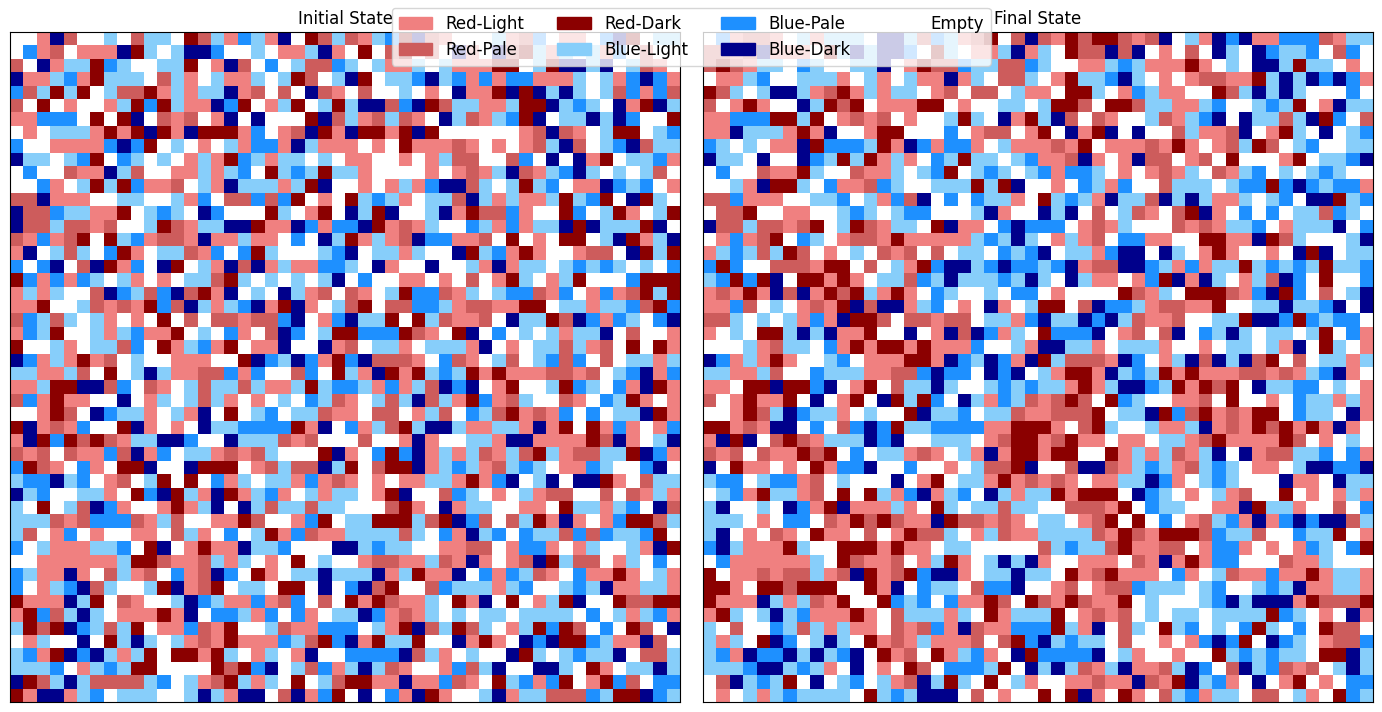

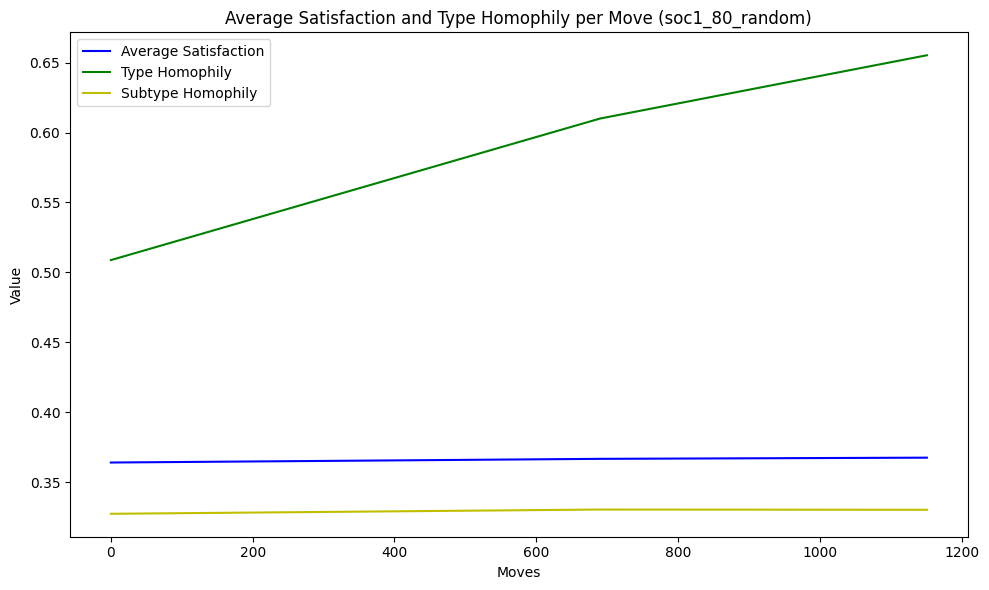

In [220]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="tolerant", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc1_80_random_agent = model.datacollector.get_agent_vars_dataframe()
soc1_80_random_model = model.datacollector.get_model_vars_dataframe()

print(soc1_80_random_agent.head())
print(soc1_80_random_model.head())

plot_initial_final_states(soc1_80_random_agent)
metrics_graph(soc1_80_random_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (37, 23)       middle       Red         Pale   
     1         (16, 9)       middle       Red        Light   
     2         (14, 0)         edge       Red        Light   
     3        (47, 47)       middle       Red         Pale   
     4          (7, 1)       middle      Blue        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      0.333333   
     1                      0.75      0        NaN      0.200000   
     2                      0.75      0        NaN      1.000000   
     3                      0.50      0        NaN      0.000000   
     4                      0.75      0        NaN      0.333333   

              Type Homophily  Subtype H

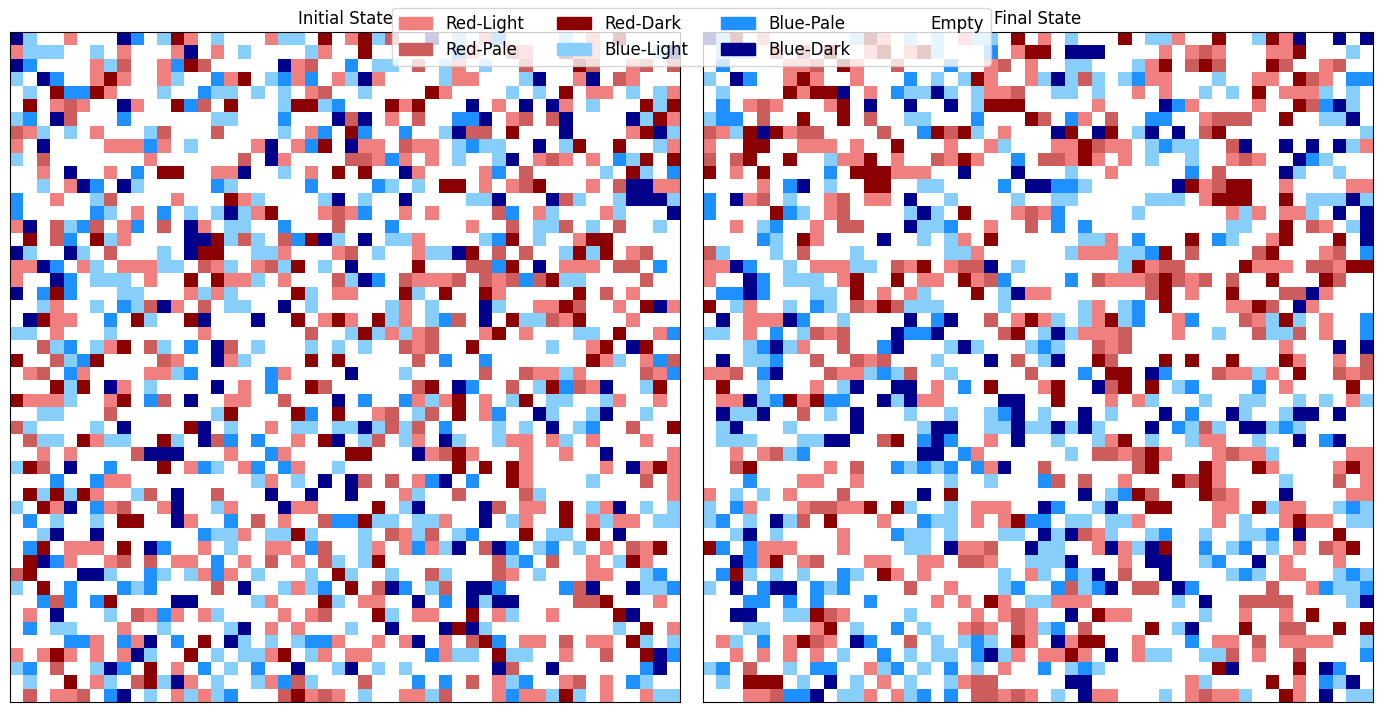

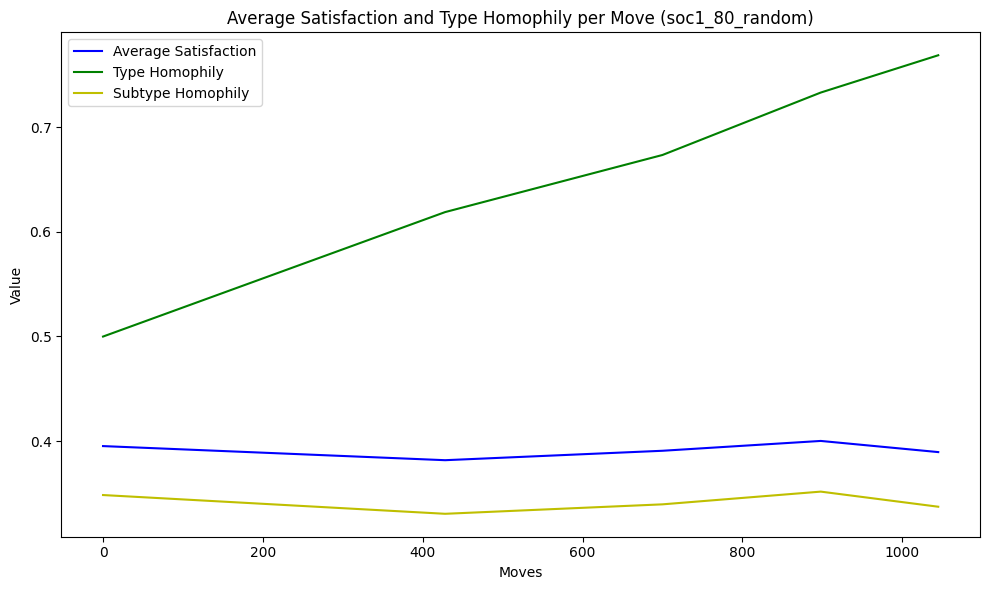

In [221]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="tolerant", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc1_50_random_agent = model.datacollector.get_agent_vars_dataframe()
soc1_50_random_model = model.datacollector.get_model_vars_dataframe()

print(soc1_50_random_agent.head())
print(soc1_50_random_model.head())

plot_initial_final_states(soc1_50_random_agent)
metrics_graph(soc1_50_random_model)

Equilibrium reached.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (26, 13)       middle      Blue        Light   
     1        (49, 28)         edge       Red         Pale   
     2         (6, 42)       middle       Red         Pale   
     3        (27, 32)       middle       Red         Dark   
     4        (23, 45)       middle      Blue        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN           0.5   
     1                      0.50      0        NaN           1.0   
     2                      0.50      0        NaN           0.0   
     3                      0.25      0        NaN           0.5   
     4                      0.75      0        NaN           0.0   

              Type Homophily  Subtype Homophily  
Step AgentID     

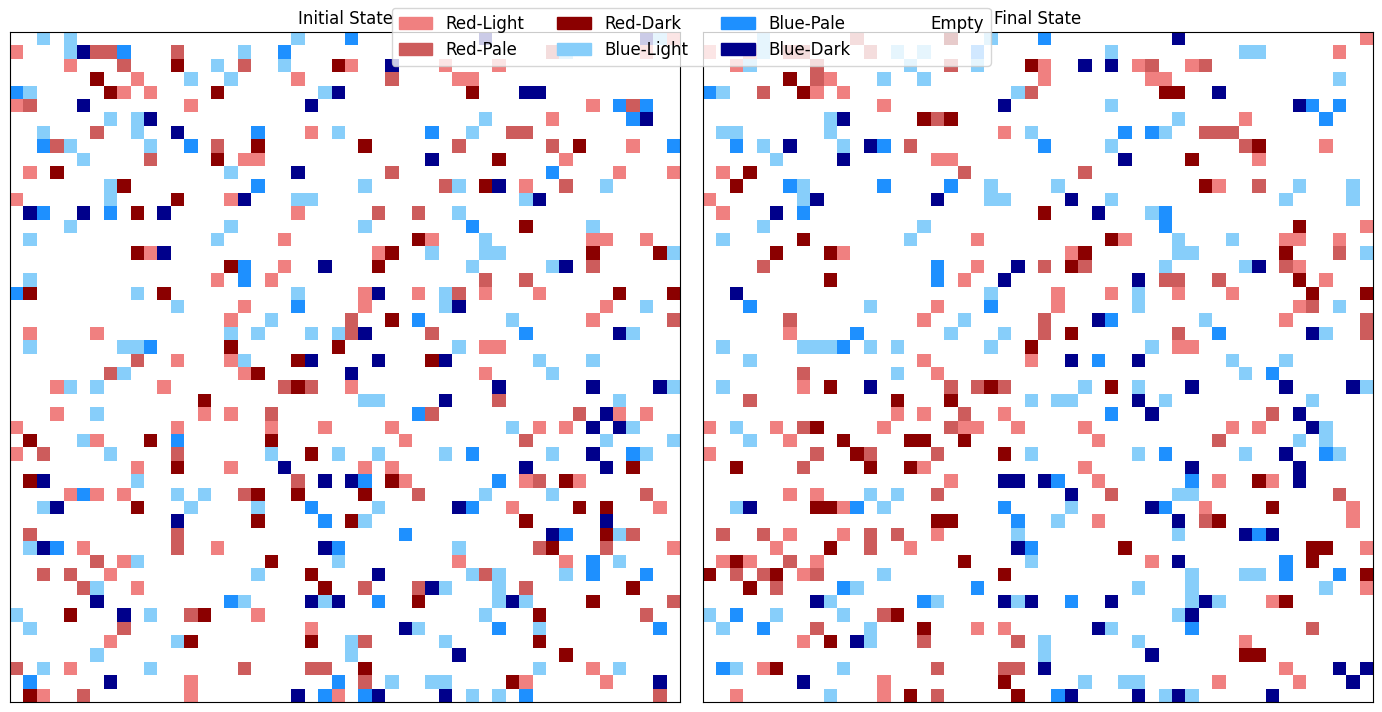

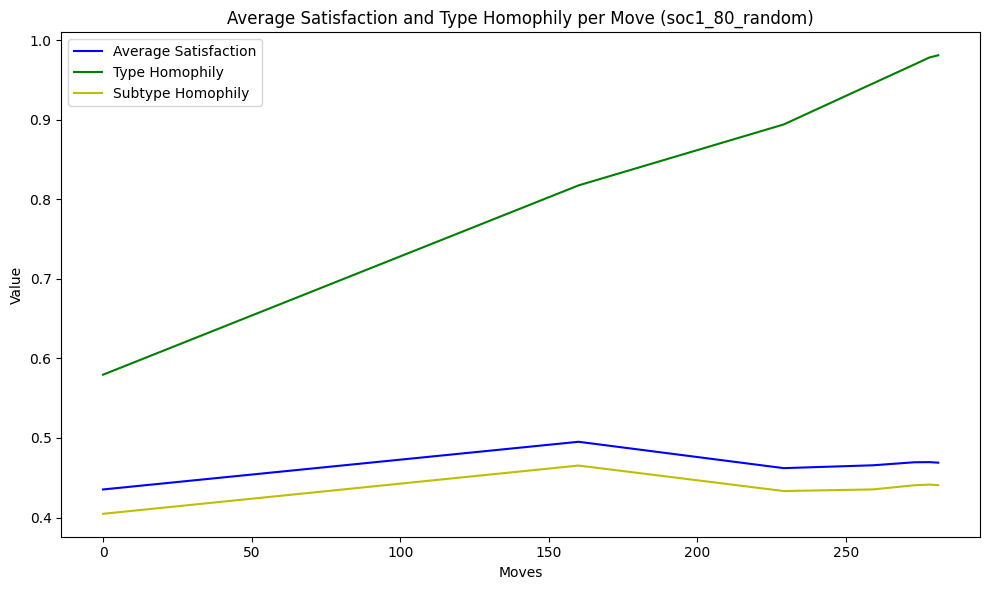

In [222]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="tolerant", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc1_20_random_agent = model.datacollector.get_agent_vars_dataframe()
soc1_20_random_model = model.datacollector.get_model_vars_dataframe()

print(soc1_20_random_agent.head())
print(soc1_20_random_model.head())

plot_initial_final_states(soc1_20_random_agent)
metrics_graph(soc1_20_random_model)

Society = 1

Strategy = Move to a Random Cell with Higher Satisfaction

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (40, 33)       middle       Red         Pale   
     1          (7, 6)       middle       Red        Light   
     2        (47, 35)       middle      Blue         Dark   
     3        (32, 26)       middle       Red        Light   
     4         (3, 31)       middle       Red        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      0.000000   
     1                      0.75      0        NaN      0.800000   
     2                      0.25      0        NaN      0.142857   
     3                      0.75      0        NaN      0.285714   
     4                      0.75      0        NaN      0.666667   

              Type Homophily  Subtype H

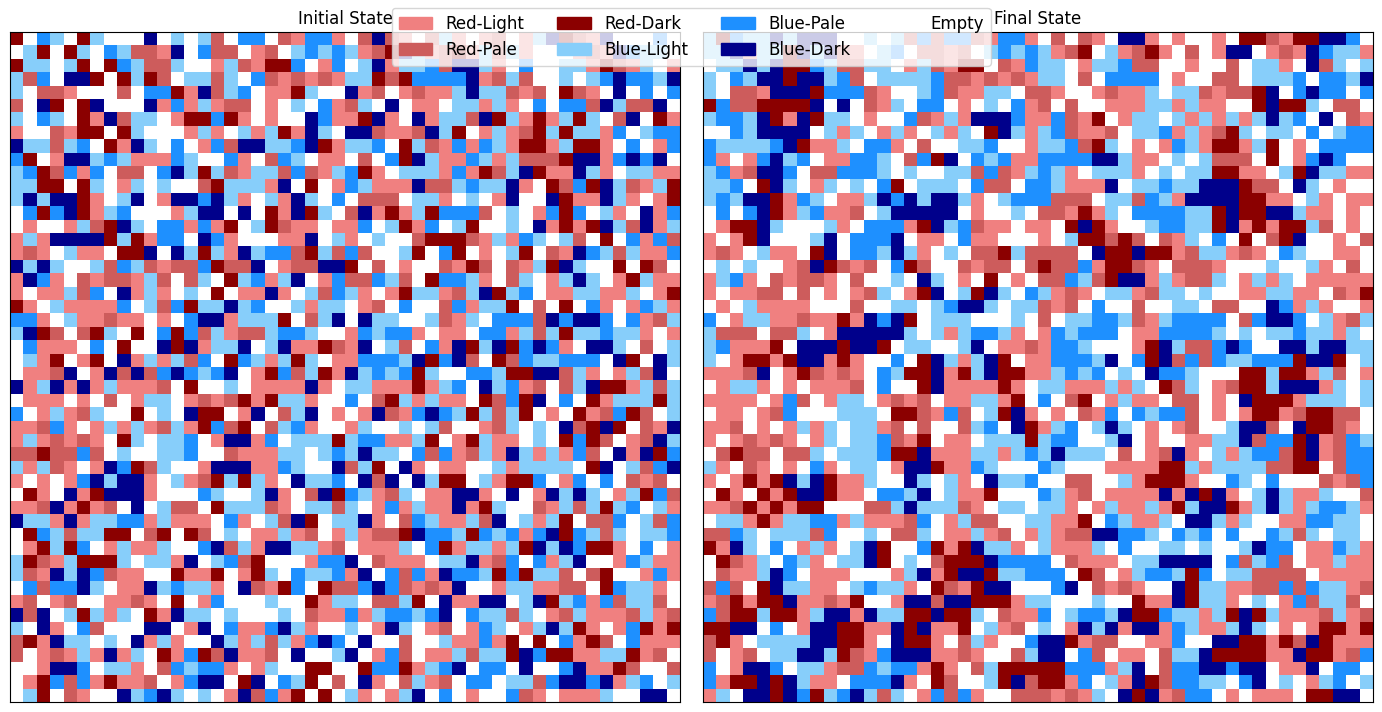

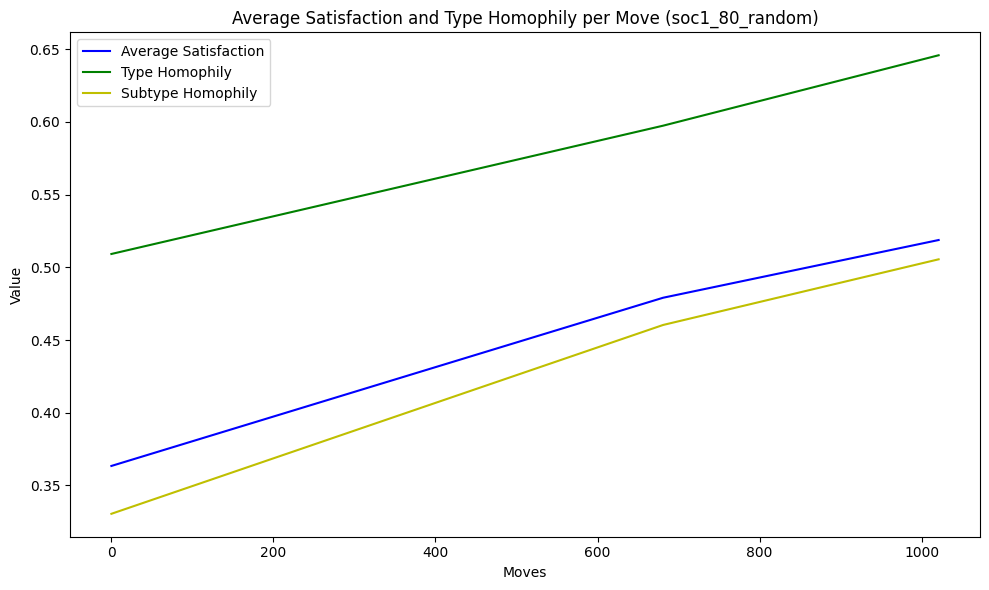

In [223]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="tolerant", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc1_80_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc1_80_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc1_80_random_hs_agent.head())
print(soc1_80_random_hs_model.head())

plot_initial_final_states(soc1_80_random_hs_agent)
metrics_graph(soc1_80_random_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (46, 21)       middle      Blue         Pale   
     1         (31, 8)       middle       Red         Pale   
     2        (28, 49)         edge      Blue         Pale   
     3        (29, 35)       middle      Blue         Dark   
     4         (36, 4)       middle      Blue         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      0.000000   
     1                      0.50      0        NaN      0.333333   
     2                      0.50      0        NaN      0.200000   
     3                      0.25      0        NaN      0.000000   
     4                      0.25      0        NaN      0.250000   

              Type Homophily  Subtype H

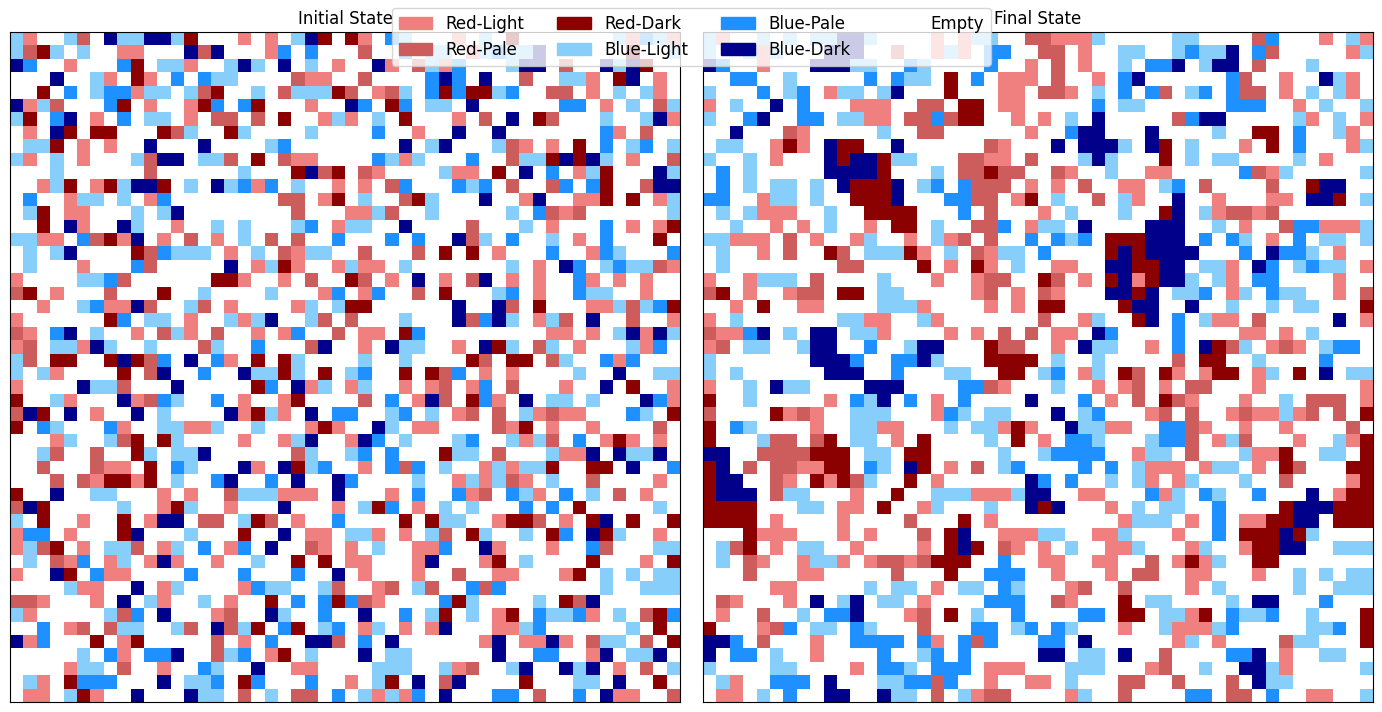

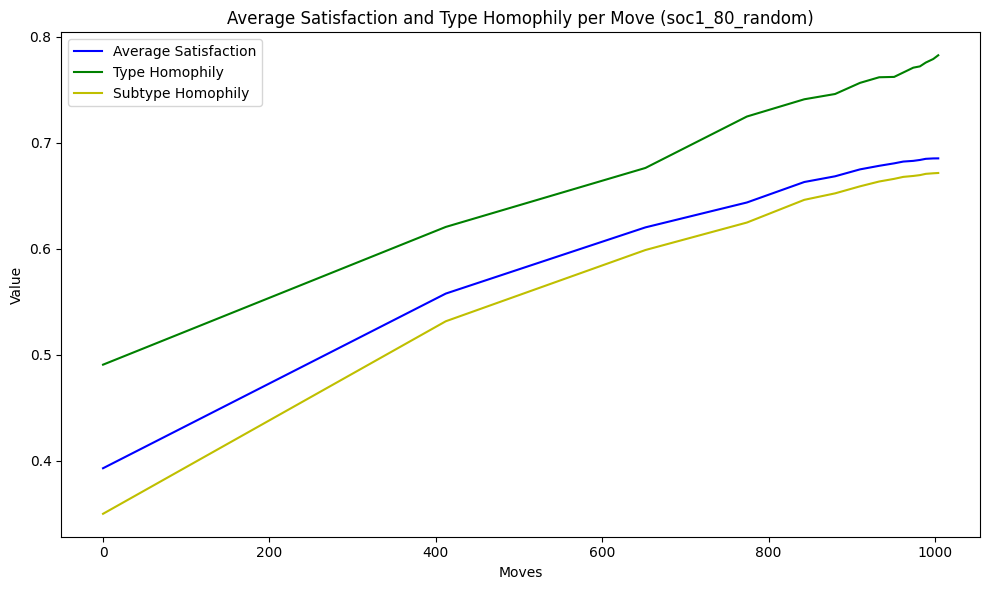

In [224]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="tolerant", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc1_50_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc1_50_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc1_50_random_hs_agent.head())
print(soc1_50_random_hs_model.head())

plot_initial_final_states(soc1_50_random_hs_agent)
metrics_graph(soc1_50_random_hs_model)

Equilibrium reached.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (16, 3)       middle      Blue        Light   
     1         (11, 7)       middle      Blue        Light   
     2        (10, 36)       middle       Red        Light   
     3         (16, 0)         edge      Blue        Light   
     4         (33, 4)       middle      Blue         Pale   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN           1.0   
     1                      0.75      0        NaN           0.5   
     2                      0.75      0        NaN           0.0   
     3                      0.75      0        NaN           0.5   
     4                      0.50      0        NaN           0.0   

              Type Homophily  Subtype Homophily  
Step AgentID     

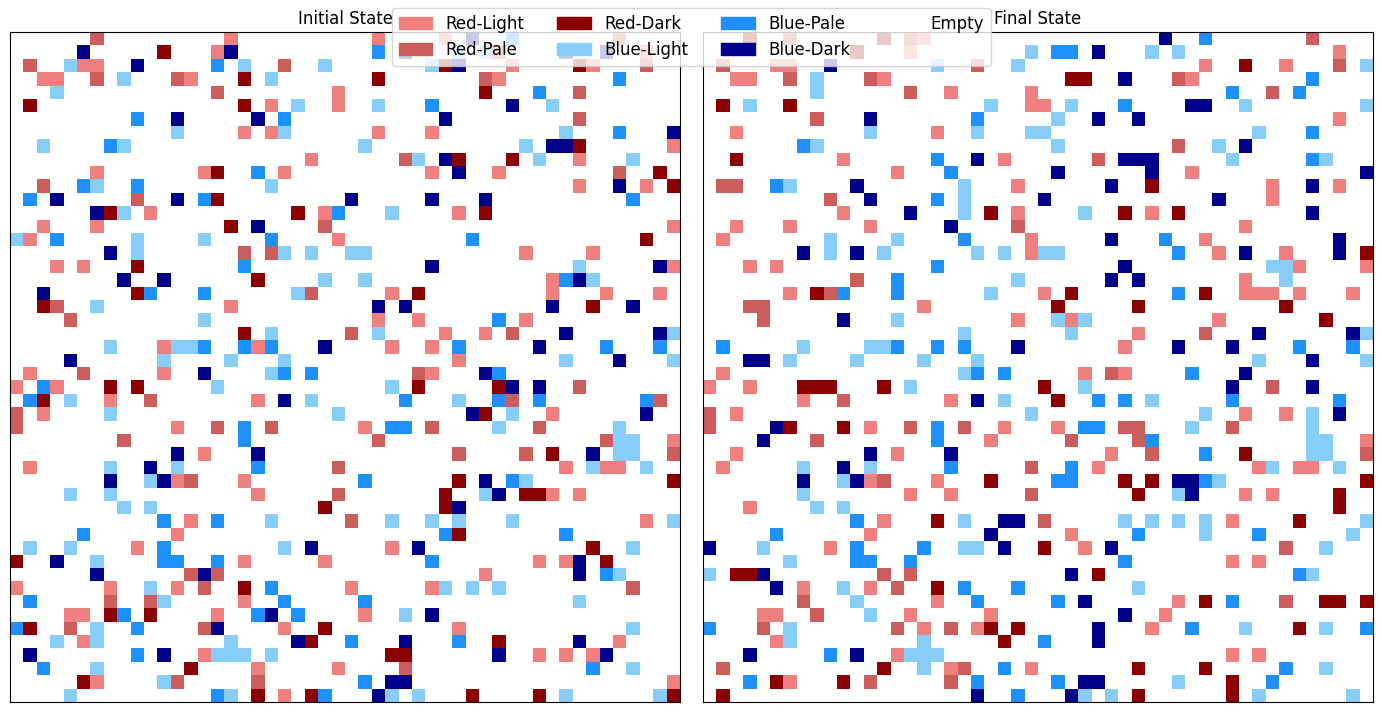

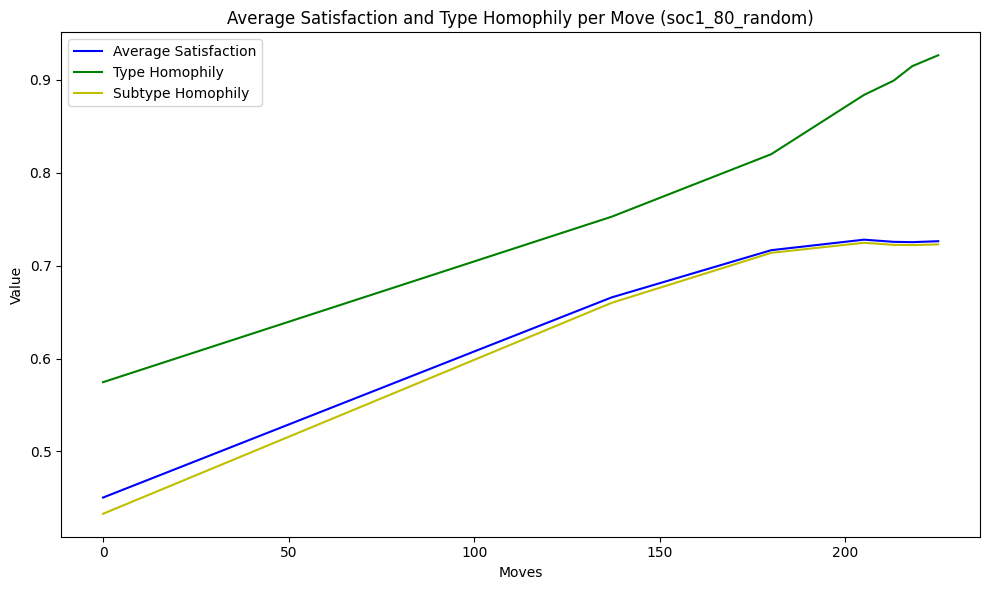

In [225]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="tolerant", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc1_20_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc1_20_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc1_20_random_hs_agent.head())
print(soc1_20_random_hs_model.head())

plot_initial_final_states(soc1_20_random_hs_agent)
metrics_graph(soc1_20_random_hs_model)

Society = 1

Strategy = Nearest highest satisfaction

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (45, 40)       middle      Blue         Dark   
     1        (41, 34)       middle      Blue        Light   
     2         (41, 3)       middle       Red         Pale   
     3         (0, 16)         edge       Red        Light   
     4         (5, 24)       middle      Blue        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.25      0        NaN      0.000000   
     1                      0.75      0        NaN      0.500000   
     2                      0.50      0        NaN      0.000000   
     3                      0.75      0        NaN      0.333333   
     4                      0.75      0        NaN      0.666667   

              Type Homophily  Subtype H

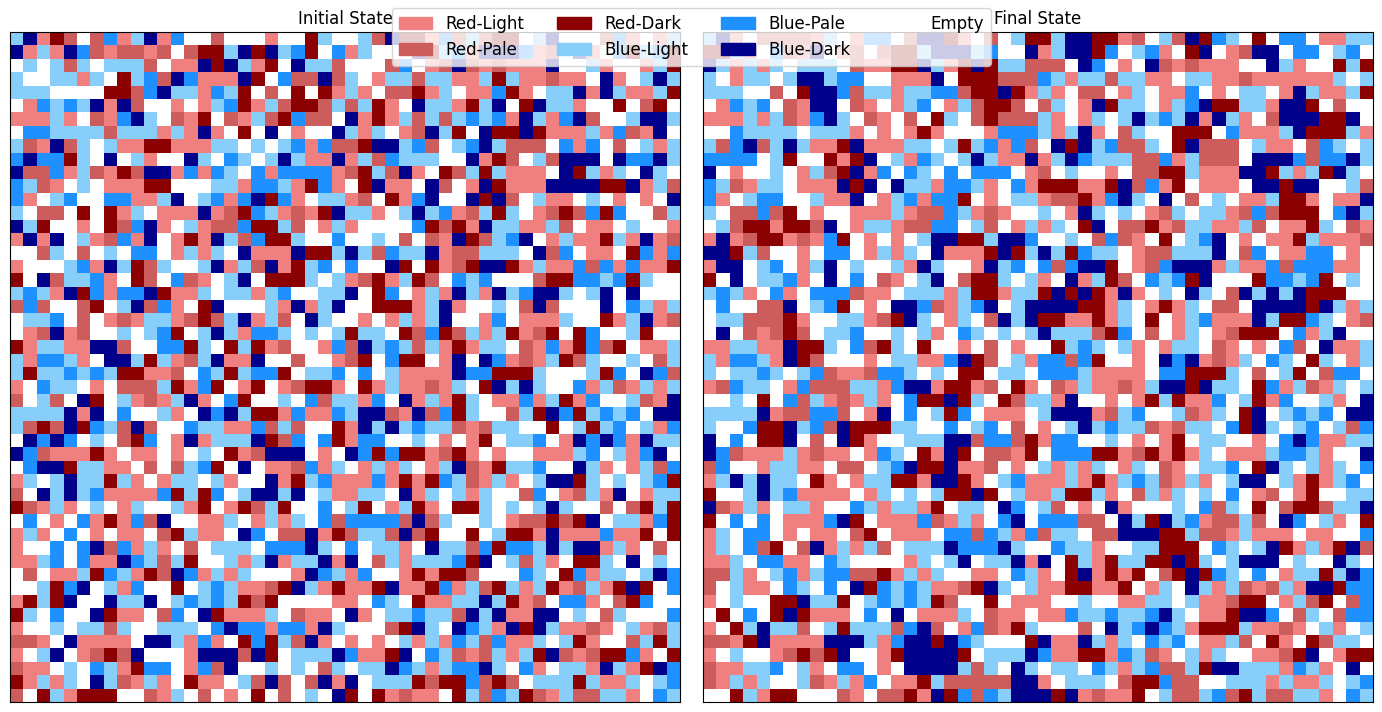

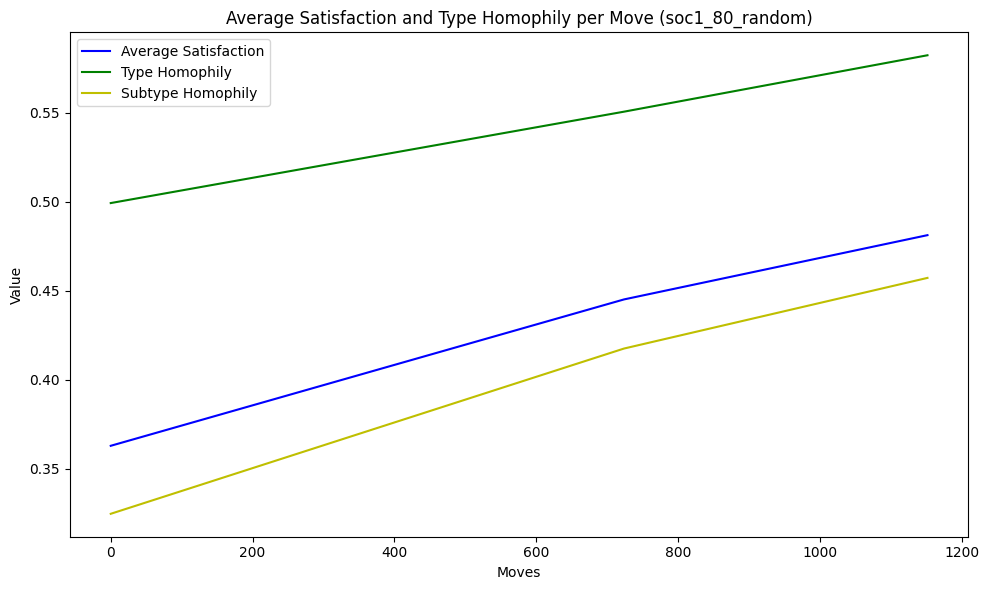

In [226]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="tolerant", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc1_80_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc1_80_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc1_80_near_hs_agent.head())
print(soc1_80_near_hs_model.head())

plot_initial_final_states(soc1_80_near_hs_agent)
metrics_graph(soc1_80_near_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (33, 30)       middle       Red        Light   
     1        (44, 11)       middle       Red        Light   
     2        (38, 24)       middle      Blue         Dark   
     3        (14, 46)       middle       Red         Pale   
     4        (49, 17)         edge      Blue        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN      0.400000   
     1                      0.75      0        NaN      0.666667   
     2                      0.25      0        NaN      0.400000   
     3                      0.50      0        NaN      0.200000   
     4                      0.75      0        NaN      0.250000   

              Type Homophily  Subtype H

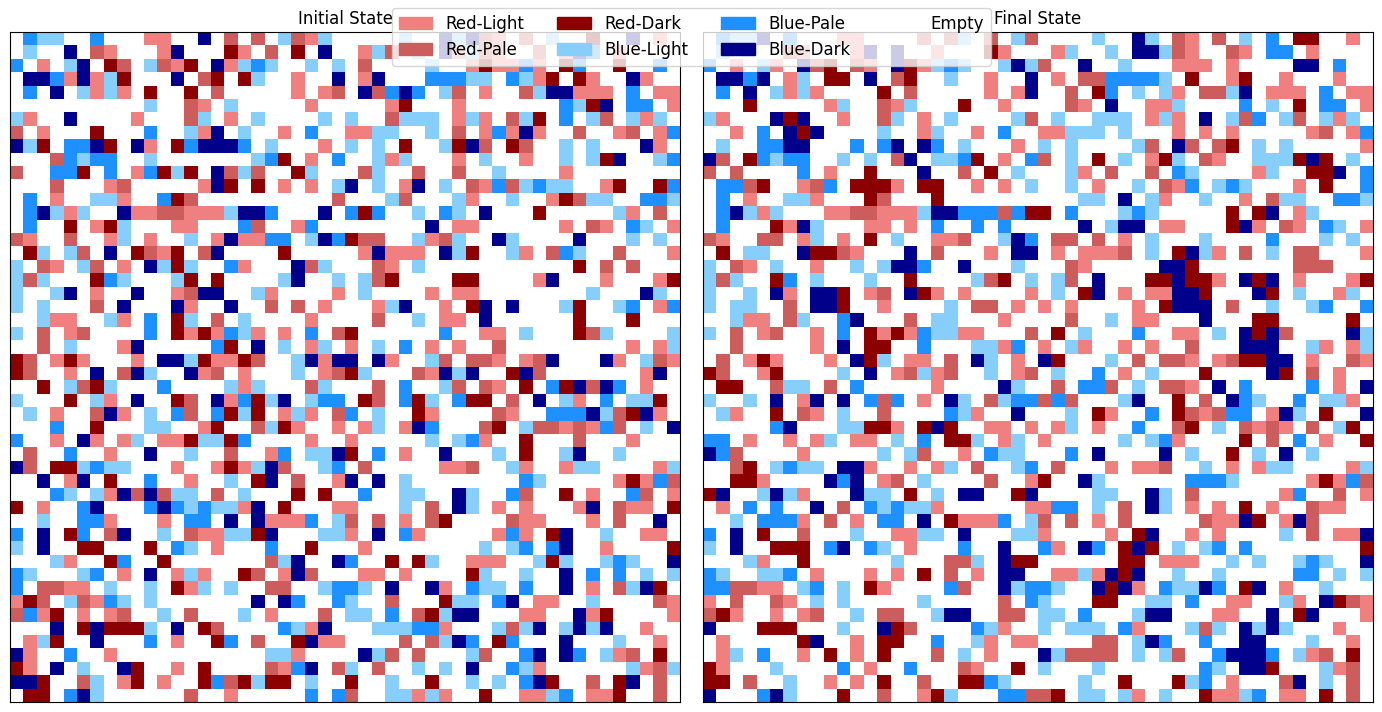

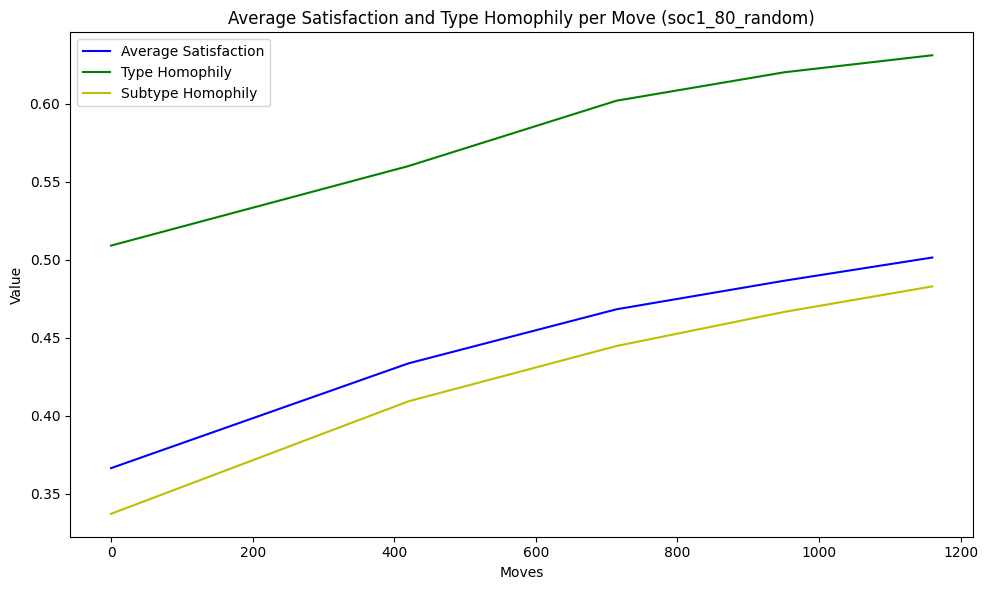

In [227]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="tolerant", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc1_50_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc1_50_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc1_50_near_hs_agent.head())
print(soc1_50_near_hs_model.head())

plot_initial_final_states(soc1_50_near_hs_agent)
metrics_graph(soc1_50_near_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (12, 28)       middle       Red         Dark   
     1        (14, 30)       middle       Red         Dark   
     2        (22, 30)       middle      Blue         Pale   
     3        (31, 30)       middle       Red         Dark   
     4        (18, 29)       middle       Red         Pale   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.25      0        NaN           0.0   
     1                      0.25      0        NaN           1.0   
     2                      0.50      0        NaN           0.4   
     3                      0.25      0        NaN           0.5   
     4                      0.50      0        NaN           0.5   

              Type Homophily  Subtype H

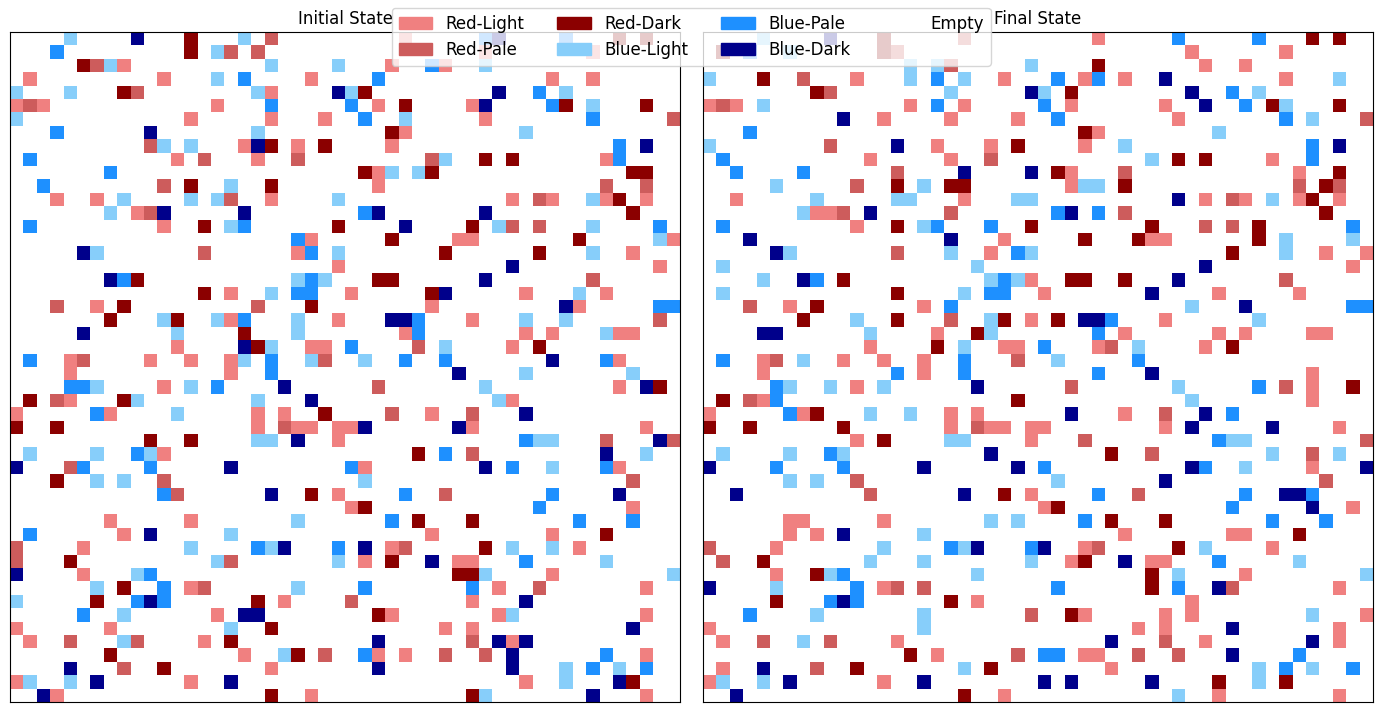

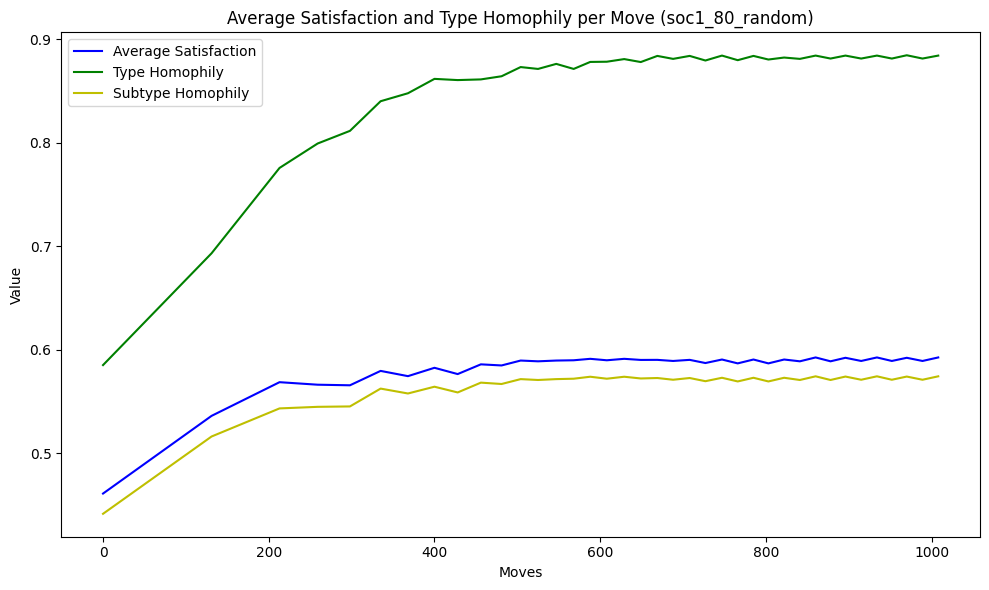

In [228]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="tolerant", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc1_20_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc1_20_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc1_20_near_hs_agent.head())
print(soc1_20_near_hs_model.head())

plot_initial_final_states(soc1_20_near_hs_agent)
metrics_graph(soc1_20_near_hs_model)

Society = 2

Strategy = Move Randomly

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0          (8, 2)       middle       Red         Pale   
     1        (13, 19)       middle      Blue         Dark   
     2        (36, 10)       middle      Blue         Pale   
     3         (4, 13)       middle       Red         Pale   
     4        (12, 15)       middle       Red         Pale   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      0.571429   
     1                      0.25      0        NaN      0.333333   
     2                      0.50      0        NaN      0.625000   
     3                      0.50      0        NaN      0.666667   
     4                      0.50      0        NaN      0.714286   

              Type Homophily  Subtype H

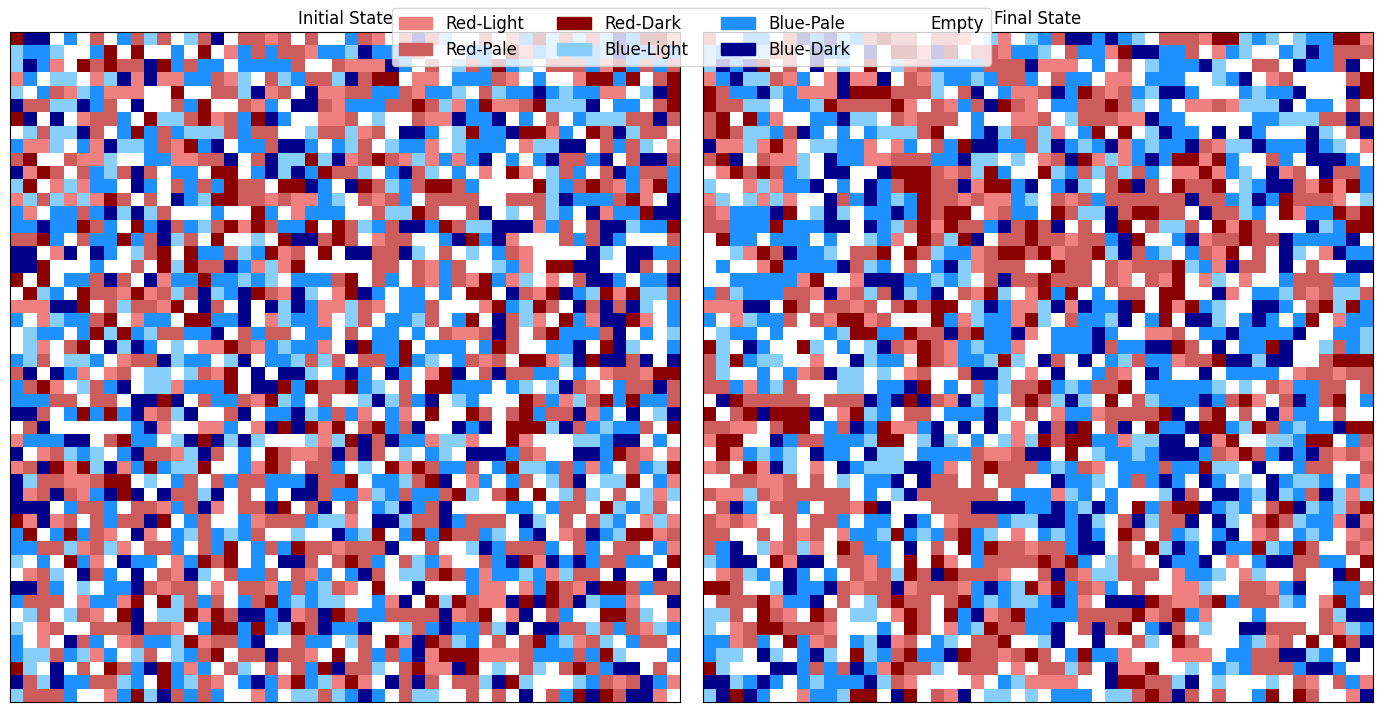

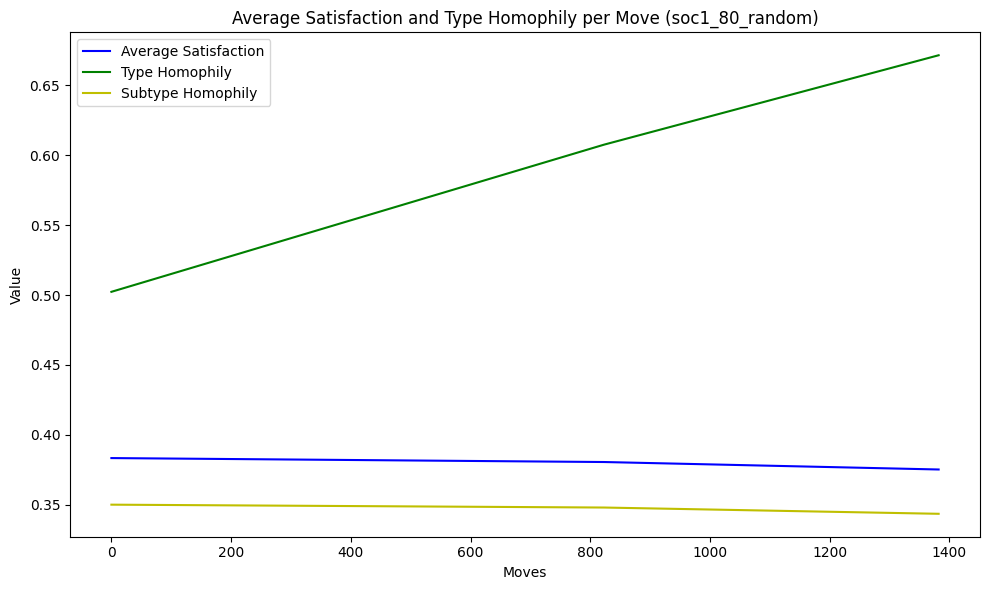

In [229]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="neutral", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc2_80_random_agent = model.datacollector.get_agent_vars_dataframe()
soc2_80_random_model = model.datacollector.get_model_vars_dataframe()

#soc1_80_random_agent['avg_satifaction'] = soc1_80_random_agent.groupby('Moves')["Satisfaction"].mean()
print(soc2_80_random_agent.head())
print(soc2_80_random_model.head())

plot_initial_final_states(soc2_80_random_agent)
metrics_graph(soc2_80_random_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (49, 4)         edge       Red         Pale   
     1         (8, 17)       middle       Red         Pale   
     2        (33, 23)       middle      Blue         Dark   
     3        (18, 20)       middle      Blue         Dark   
     4         (26, 0)         edge      Blue         Pale   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN          0.50   
     1                      0.50      0        NaN          0.25   
     2                      0.25      0        NaN          0.00   
     3                      0.25      0        NaN          0.00   
     4                      0.50      0        NaN          1.00   

              Type Homophily  Subtype H

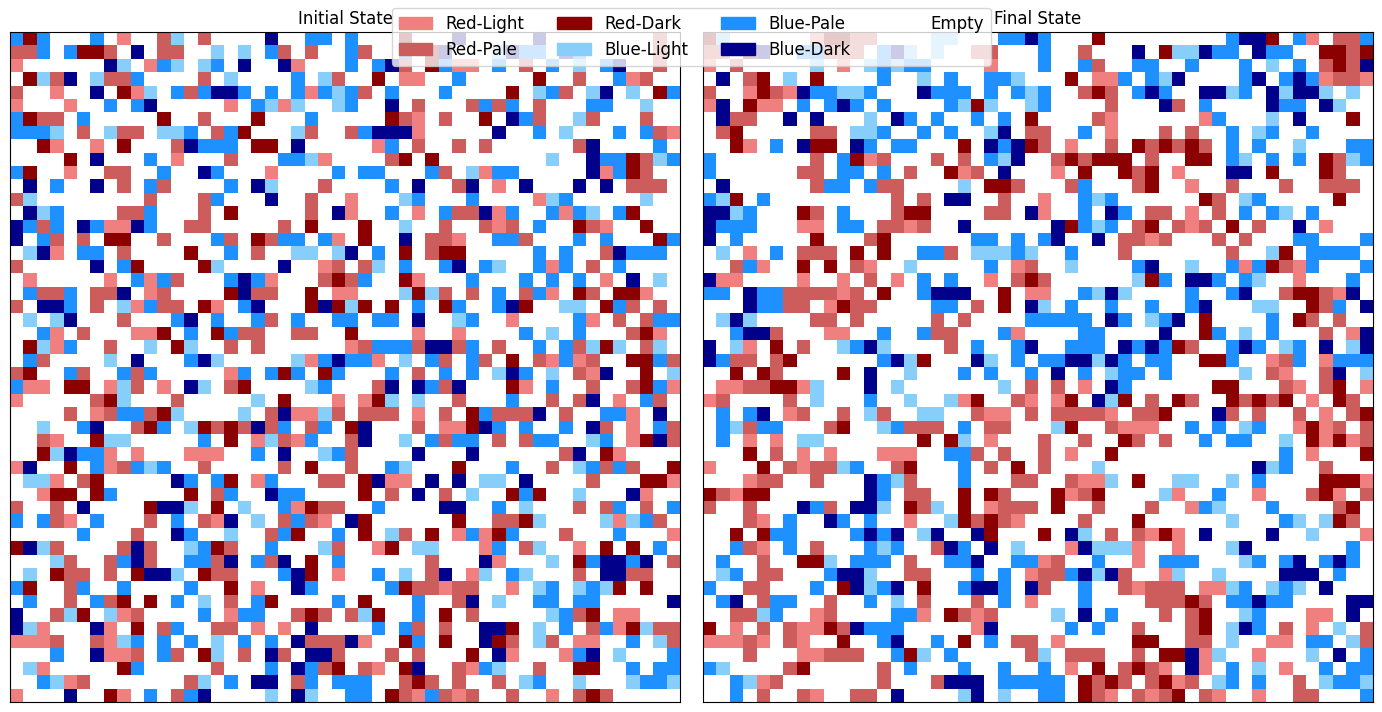

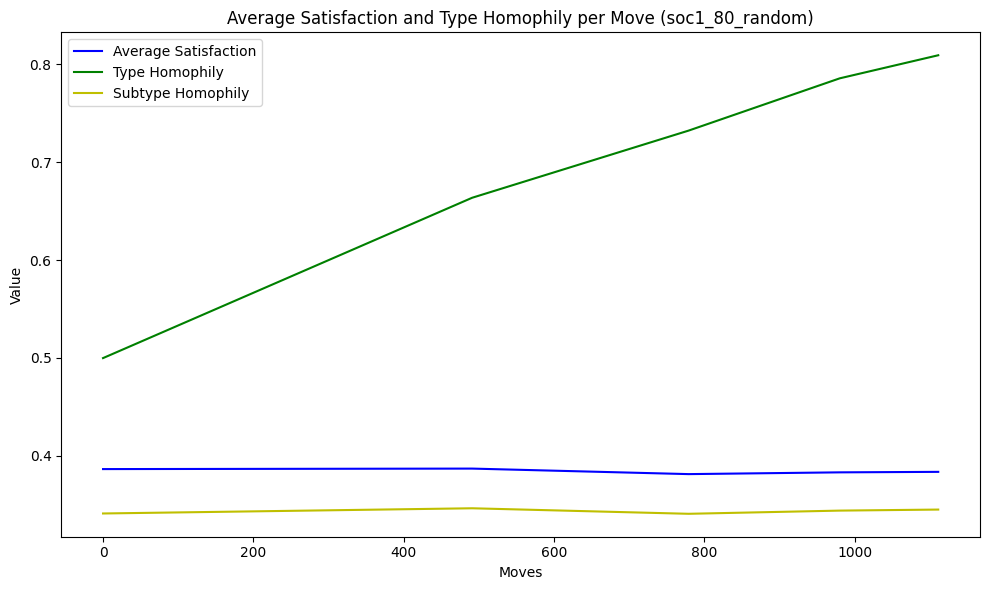

In [230]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="neutral", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc2_50_random_agent = model.datacollector.get_agent_vars_dataframe()
soc2_50_random_model = model.datacollector.get_model_vars_dataframe()

print(soc2_50_random_agent.head())
print(soc2_50_random_model.head())

plot_initial_final_states(soc2_50_random_agent)
metrics_graph(soc2_50_random_model)

Equilibrium reached.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (39, 16)       middle       Red         Pale   
     1        (35, 47)       middle       Red        Light   
     2        (23, 28)       middle      Blue         Dark   
     3        (35, 13)       middle       Red         Pale   
     4         (5, 14)       middle      Blue         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      1.000000   
     1                      0.75      0        NaN      0.000000   
     2                      0.25      0        NaN      0.000000   
     3                      0.50      0        NaN      0.000000   
     4                      0.25      0        NaN      0.666667   

              Type Homophily  Subtype Homophily  
Step AgentID     

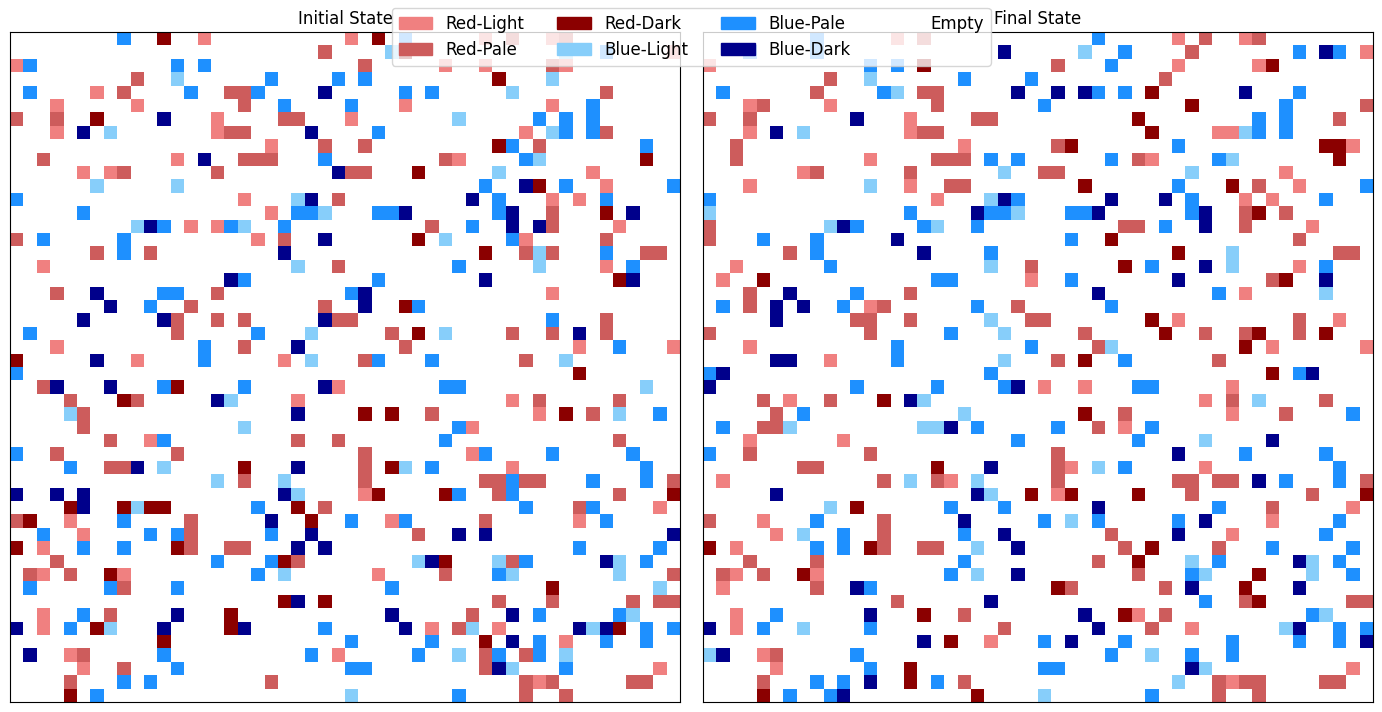

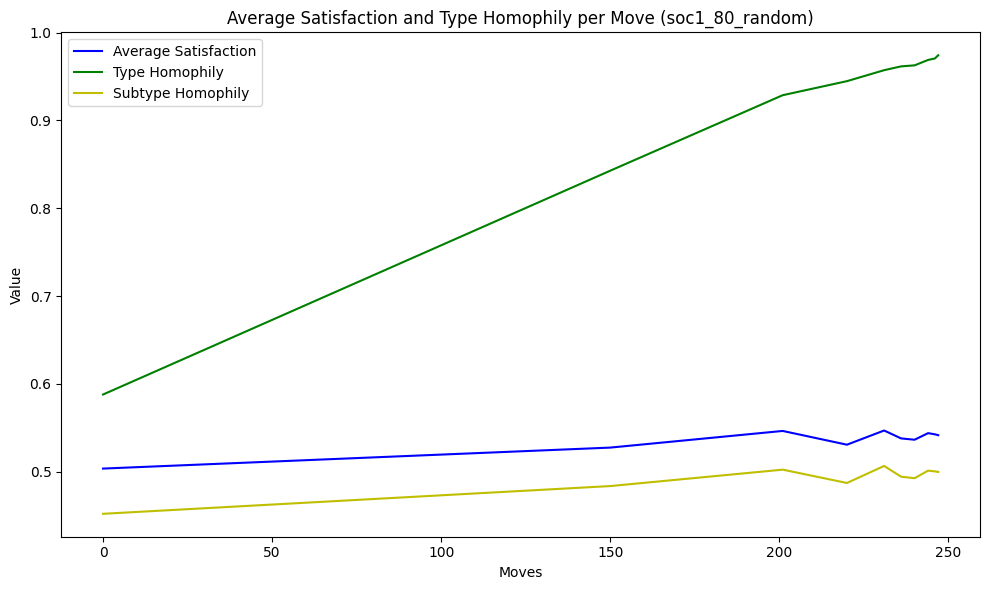

In [231]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="neutral", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc2_20_random_agent = model.datacollector.get_agent_vars_dataframe()
soc2_20_random_model = model.datacollector.get_model_vars_dataframe()

print(soc2_20_random_agent.head())
print(soc2_20_random_model.head())

plot_initial_final_states(soc2_20_random_agent)
metrics_graph(soc2_20_random_model)

Society = 2

Strategy = Move to a Random Cell with Higher Satisfaction

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (1, 14)       middle       Red        Light   
     1        (13, 44)       middle      Blue         Pale   
     2        (42, 16)       middle      Blue         Pale   
     3        (21, 19)       middle      Blue         Pale   
     4         (1, 30)       middle      Blue        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN      0.125000   
     1                      0.50      0        NaN      0.285714   
     2                      0.50      0        NaN      0.666667   
     3                      0.50      0        NaN      0.333333   
     4                      0.75      0        NaN      0.166667   

              Type Homophily  Subtype H

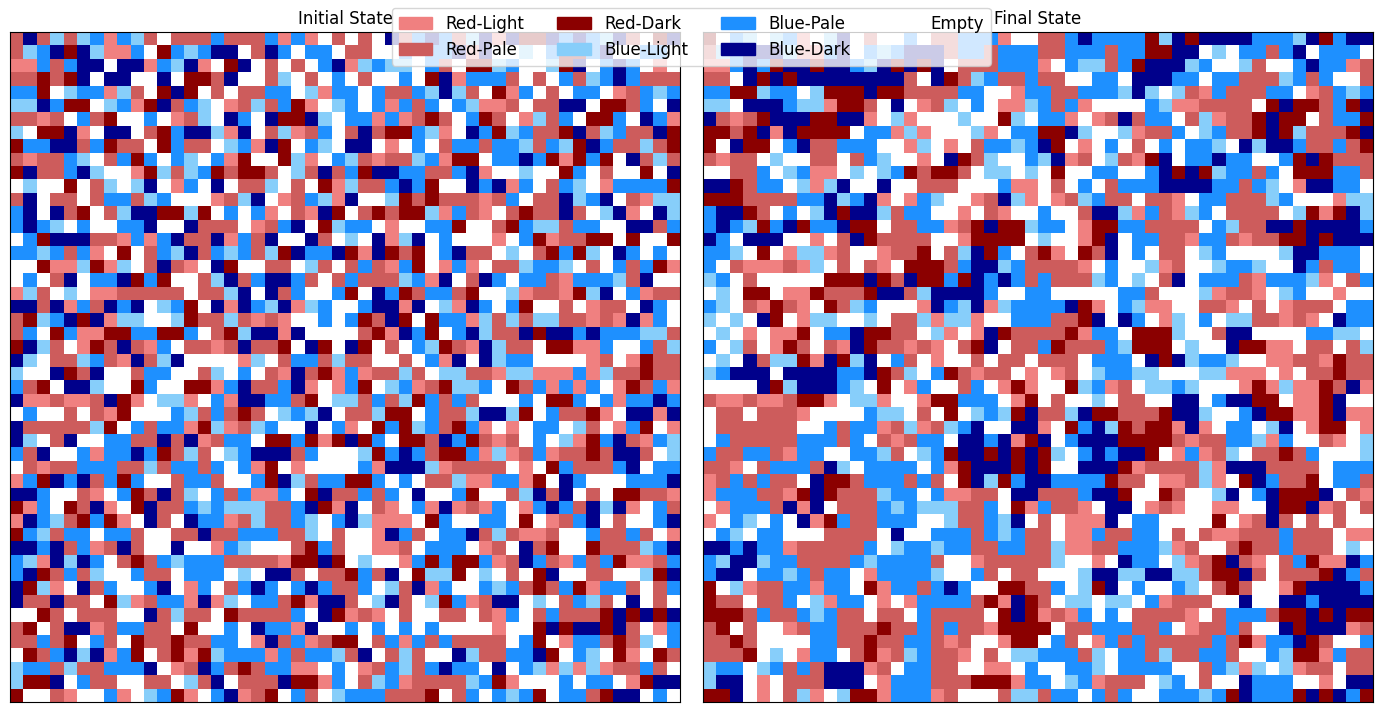

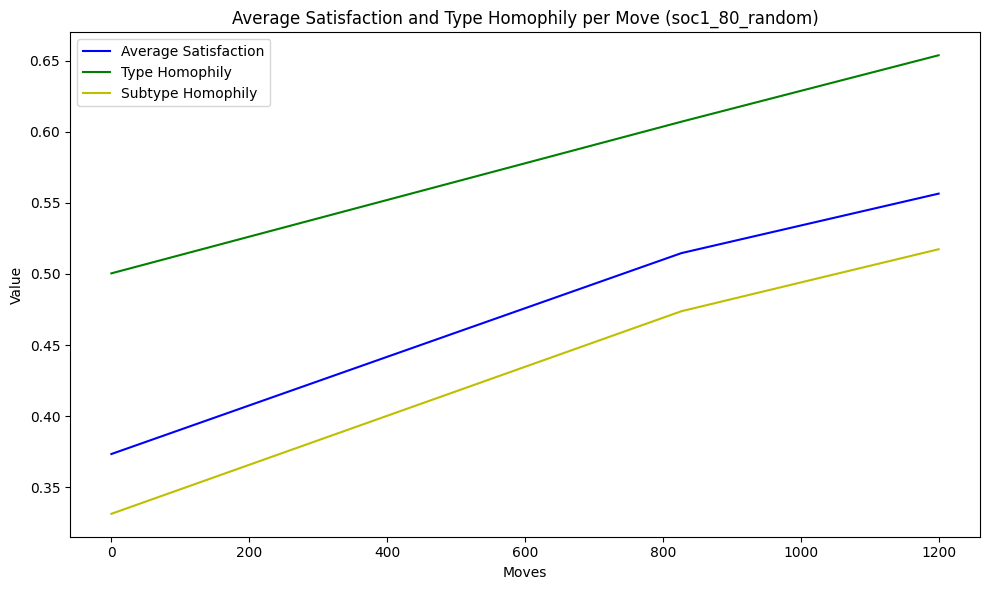

In [232]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="neutral", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc2_80_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc2_80_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc2_80_random_hs_agent.head())
print(soc2_80_random_hs_model.head())

plot_initial_final_states(soc2_80_random_hs_agent)
metrics_graph(soc2_80_random_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (24, 40)       middle       Red         Dark   
     1        (28, 25)       middle       Red         Pale   
     2         (31, 5)       middle      Blue         Pale   
     3         (24, 8)       middle       Red         Pale   
     4        (14, 41)       middle      Blue         Pale   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.25      0        NaN      0.000000   
     1                      0.50      0        NaN      0.500000   
     2                      0.50      0        NaN      0.500000   
     3                      0.50      0        NaN      0.333333   
     4                      0.50      0        NaN      1.000000   

              Type Homophily  Subtype H

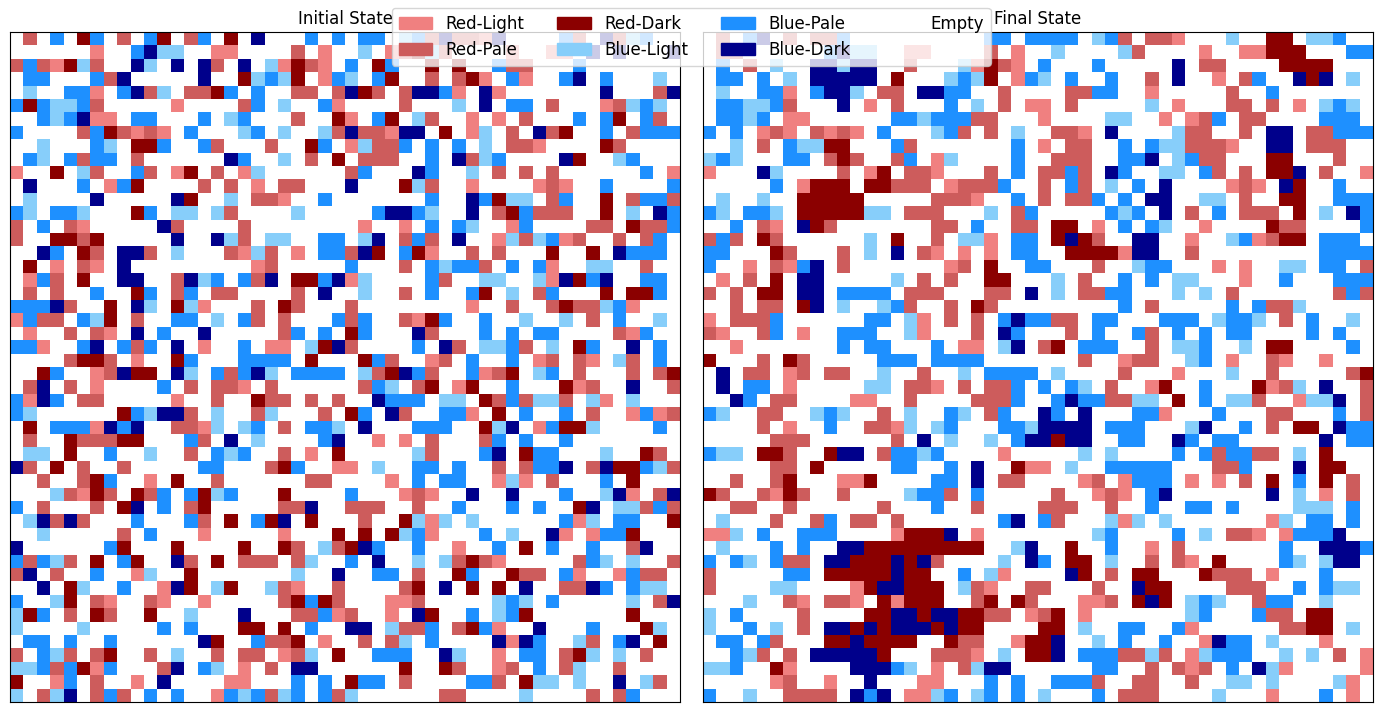

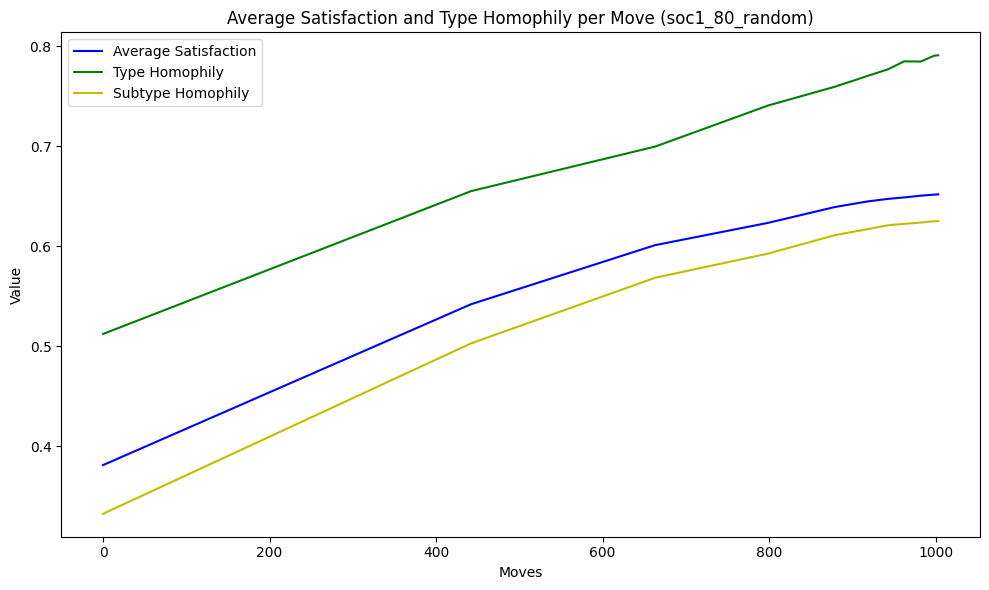

In [233]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="neutral", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc2_50_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc2_50_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc2_50_random_hs_agent.head())
print(soc2_50_random_hs_model.head())

plot_initial_final_states(soc2_50_random_hs_agent)
metrics_graph(soc2_50_random_hs_model)

Equilibrium reached.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (38, 18)       middle       Red         Dark   
     1        (14, 45)       middle       Red         Dark   
     2        (45, 16)       middle      Blue         Dark   
     3         (22, 8)       middle       Red         Pale   
     4        (16, 25)       middle      Blue         Pale   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.25      0        NaN           0.0   
     1                      0.25      0        NaN           1.0   
     2                      0.25      0        NaN           0.0   
     3                      0.50      0        NaN           1.0   
     4                      0.50      0        NaN           1.0   

              Type Homophily  Subtype Homophily  
Step AgentID     

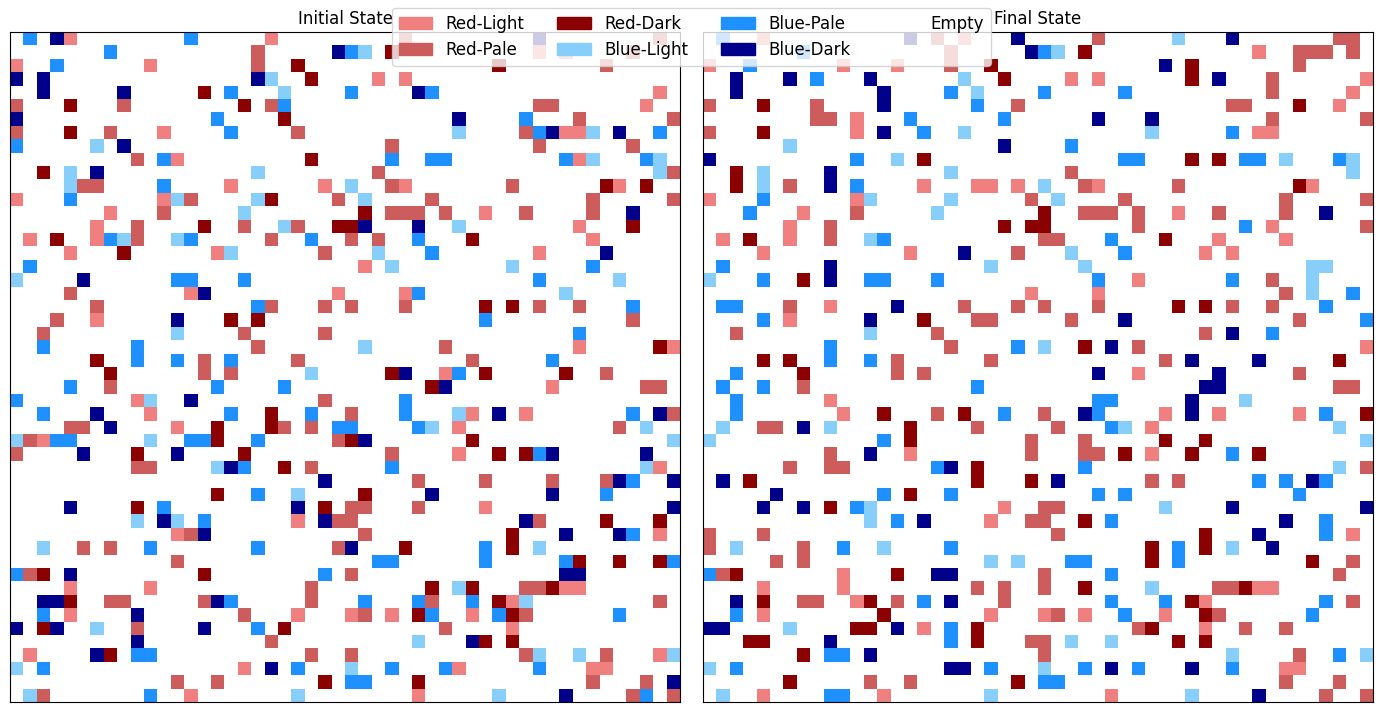

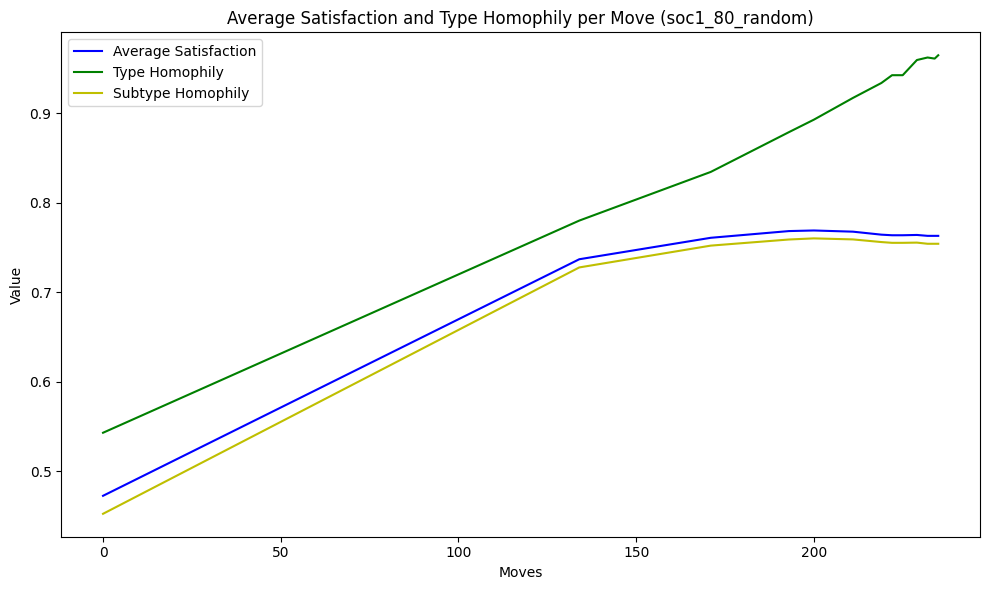

In [234]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="neutral", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc2_20_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc2_20_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc2_20_random_hs_agent.head())
print(soc2_20_random_hs_model.head())

plot_initial_final_states(soc2_20_random_hs_agent)
metrics_graph(soc2_20_random_hs_model)

Society = 2
 
Strategy = Nearest highest satisfaction

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (15, 2)       middle      Blue        Light   
     1        (25, 14)       middle       Red        Light   
     2        (14, 18)       middle      Blue         Pale   
     3        (25, 47)       middle      Blue         Pale   
     4         (9, 23)       middle      Blue         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN      0.250000   
     1                      0.75      0        NaN      0.333333   
     2                      0.50      0        NaN      0.600000   
     3                      0.50      0        NaN      0.666667   
     4                      0.25      0        NaN      0.200000   

              Type Homophily  Subtype H

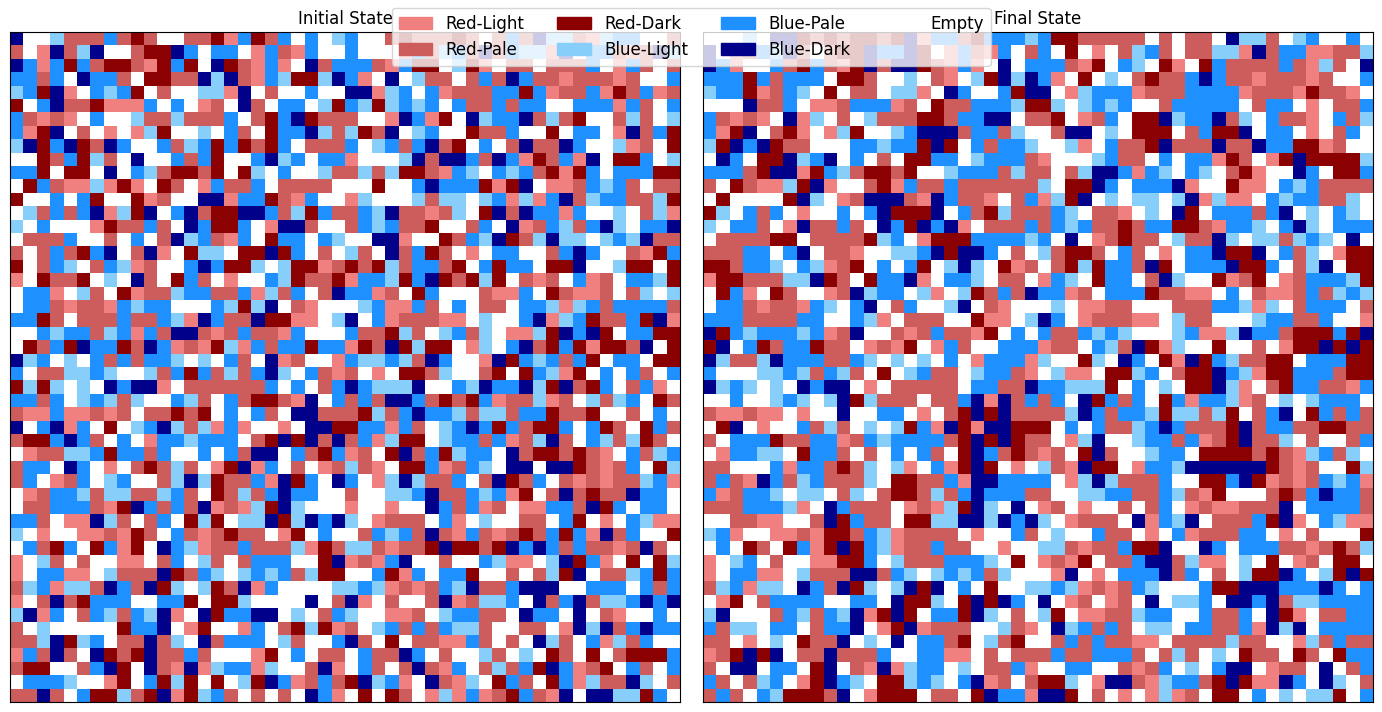

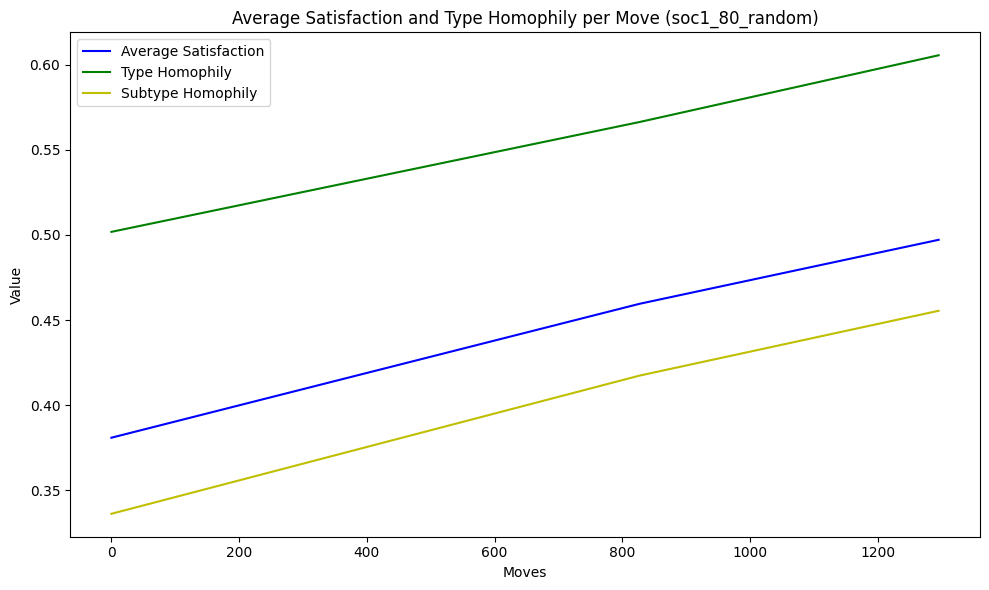

In [235]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="neutral", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc2_80_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc2_80_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc2_80_near_hs_agent.head())
print(soc2_80_near_hs_model.head())

plot_initial_final_states(soc2_80_near_hs_agent)
metrics_graph(soc2_80_near_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0          (5, 3)       middle       Red         Pale   
     1         (34, 1)       middle       Red         Pale   
     2        (17, 40)       middle      Blue         Dark   
     3         (7, 39)       middle       Red         Dark   
     4        (39, 15)       middle      Blue        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      0.714286   
     1                      0.50      0        NaN      0.500000   
     2                      0.25      0        NaN      0.000000   
     3                      0.25      0        NaN      0.250000   
     4                      0.75      0        NaN      0.250000   

              Type Homophily  Subtype H

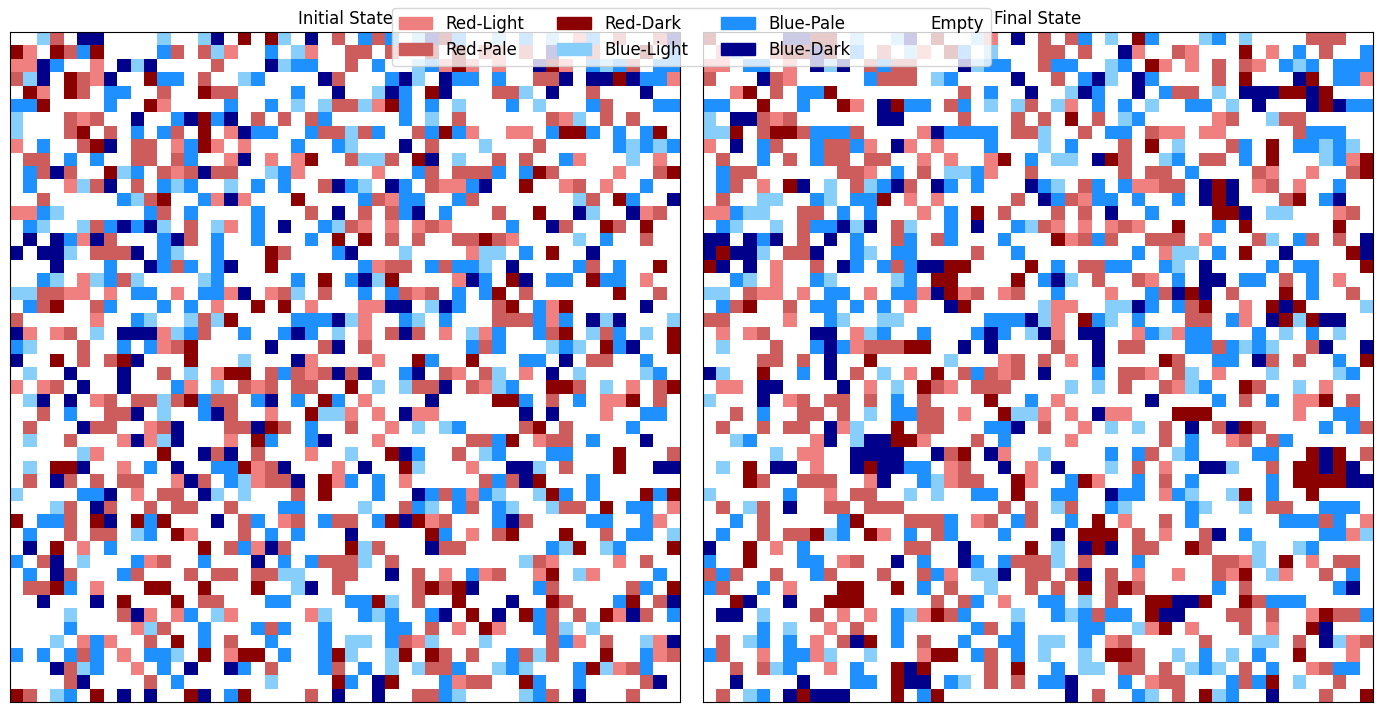

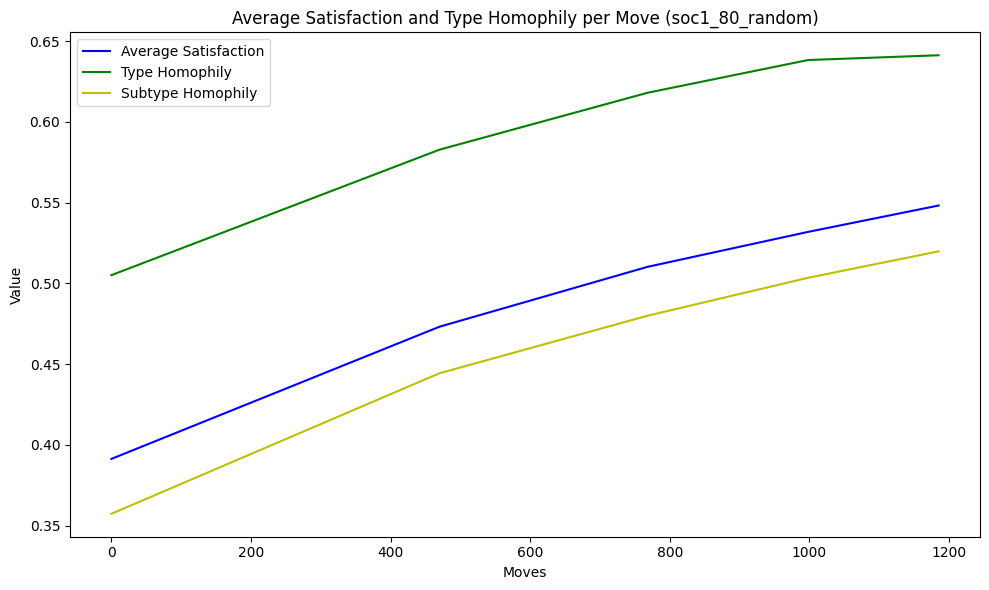

In [236]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="neutral", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc2_50_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc2_50_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc2_50_near_hs_agent.head())
print(soc2_50_near_hs_model.head())

plot_initial_final_states(soc2_50_near_hs_agent)
metrics_graph(soc2_50_near_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (4, 34)       middle      Blue        Light   
     1         (5, 20)       middle       Red        Light   
     2        (44, 39)       middle      Blue         Dark   
     3        (11, 21)       middle       Red        Light   
     4        (36, 10)       middle       Red         Pale   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN           0.0   
     1                      0.75      0        NaN           0.0   
     2                      0.25      0        NaN           1.0   
     3                      0.75      0        NaN           1.0   
     4                      0.50      0        NaN           0.0   

              Type Homophily  Subtype H

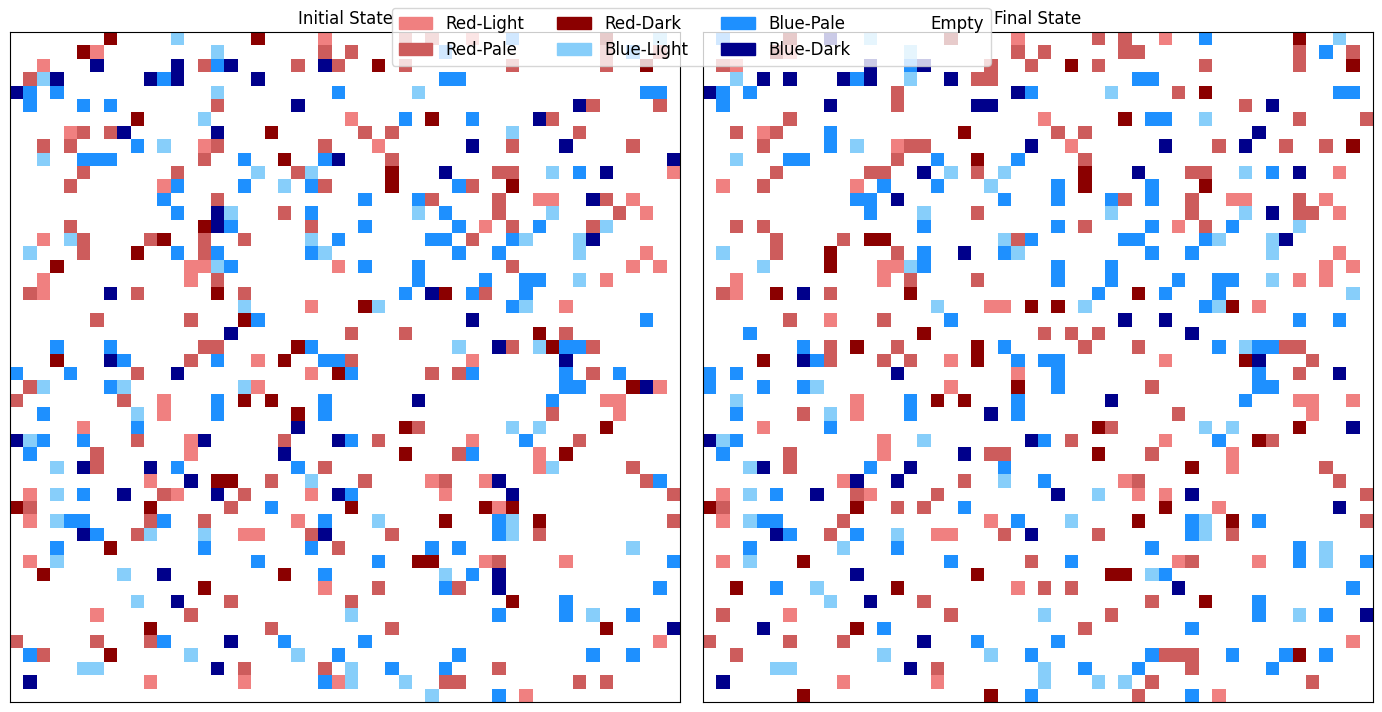

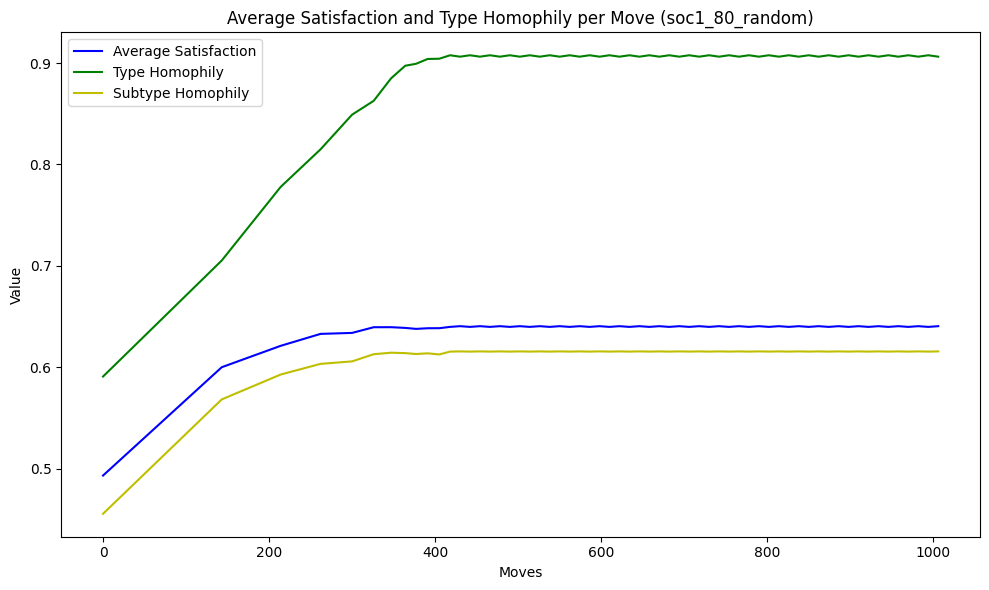

In [237]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="neutral", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc2_20_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc2_20_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc2_20_near_hs_agent.head())
print(soc2_20_near_hs_model.head())

plot_initial_final_states(soc2_20_near_hs_agent)
metrics_graph(soc2_20_near_hs_model)

Society = 3

Strategy = Move Randomly

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (35, 48)       middle      Blue         Dark   
     1         (6, 28)       middle      Blue         Dark   
     2         (19, 1)       middle       Red         Dark   
     3         (28, 9)       middle       Red        Light   
     4          (8, 7)       middle       Red         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.25      0        NaN      0.142857   
     1                      0.25      0        NaN      0.571429   
     2                      0.25      0        NaN      0.500000   
     3                      0.75      0        NaN      0.200000   
     4                      0.25      0        NaN      0.800000   

              Type Homophily  Subtype H

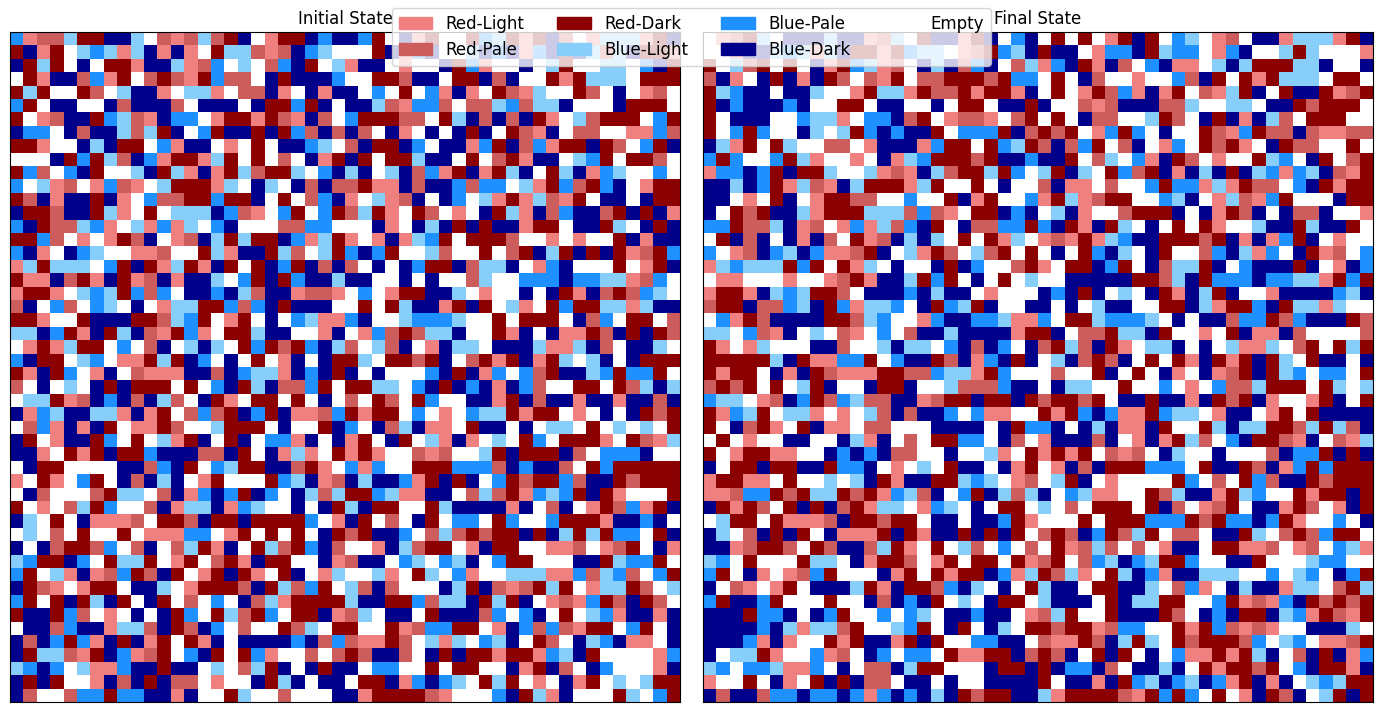

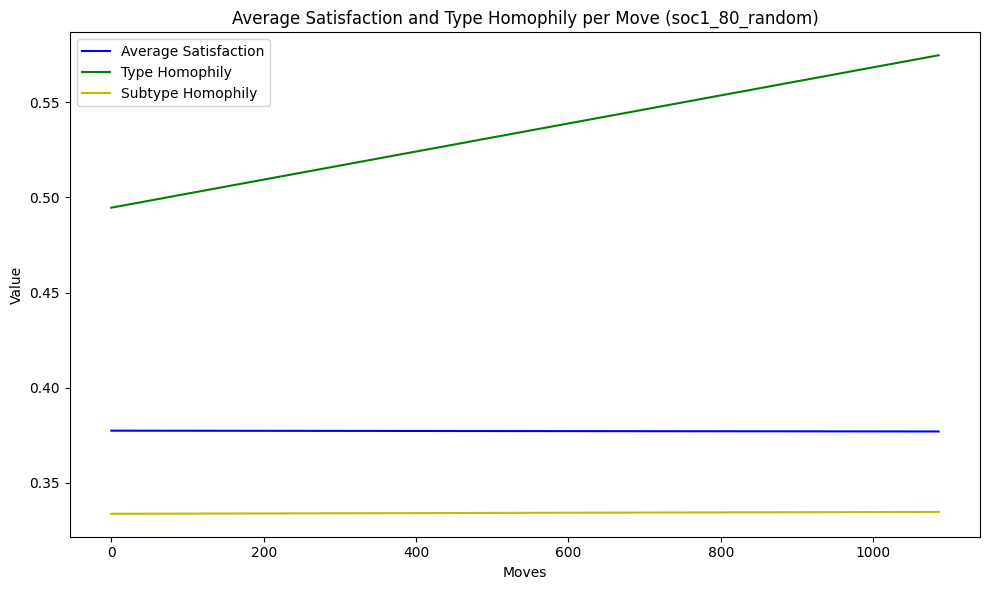

In [238]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="intolerant", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc3_80_random_agent = model.datacollector.get_agent_vars_dataframe()
soc3_80_random_model = model.datacollector.get_model_vars_dataframe()

print(soc3_80_random_agent.head())
print(soc3_80_random_model.head())

plot_initial_final_states(soc3_80_random_agent)
metrics_graph(soc3_80_random_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (1, 10)       middle       Red         Pale   
     1        (15, 15)       middle       Red         Dark   
     2        (12, 14)       middle       Red         Dark   
     3        (29, 30)       middle      Blue         Pale   
     4        (16, 29)       middle       Red         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      0.285714   
     1                      0.25      0        NaN      0.000000   
     2                      0.25      0        NaN      0.500000   
     3                      0.50      0        NaN      0.000000   
     4                      0.25      0        NaN      0.500000   

              Type Homophily  Subtype H

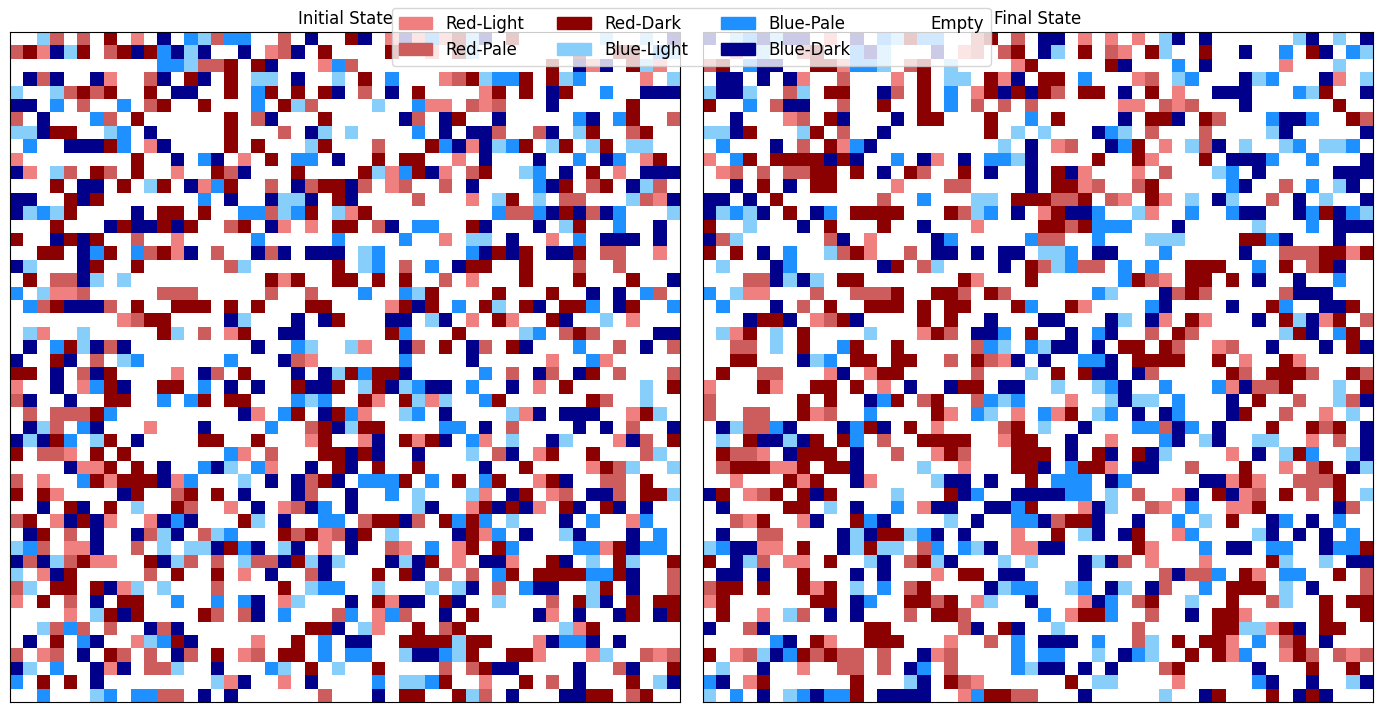

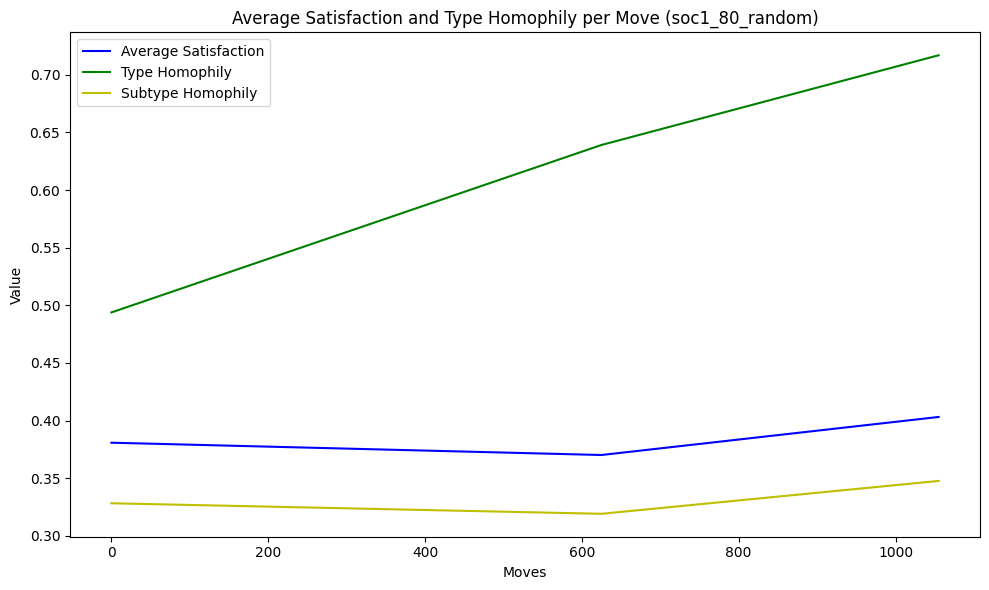

In [239]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="intolerant", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc3_50_random_agent = model.datacollector.get_agent_vars_dataframe()
soc3_50_random_model = model.datacollector.get_model_vars_dataframe()

print(soc3_50_random_agent.head())
print(soc3_50_random_model.head())

plot_initial_final_states(soc3_50_random_agent)
metrics_graph(soc3_50_random_model)

Equilibrium reached.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (41, 7)       middle      Blue        Light   
     1         (7, 40)       middle       Red        Light   
     2         (6, 36)       middle       Red         Dark   
     3        (19, 36)       middle      Blue         Dark   
     4        (37, 49)         edge       Red         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN      1.000000   
     1                      0.75      0        NaN      1.000000   
     2                      0.25      0        NaN      1.000000   
     3                      0.25      0        NaN      0.333333   
     4                      0.25      0        NaN      1.000000   

              Type Homophily  Subtype Homophily  
Step AgentID     

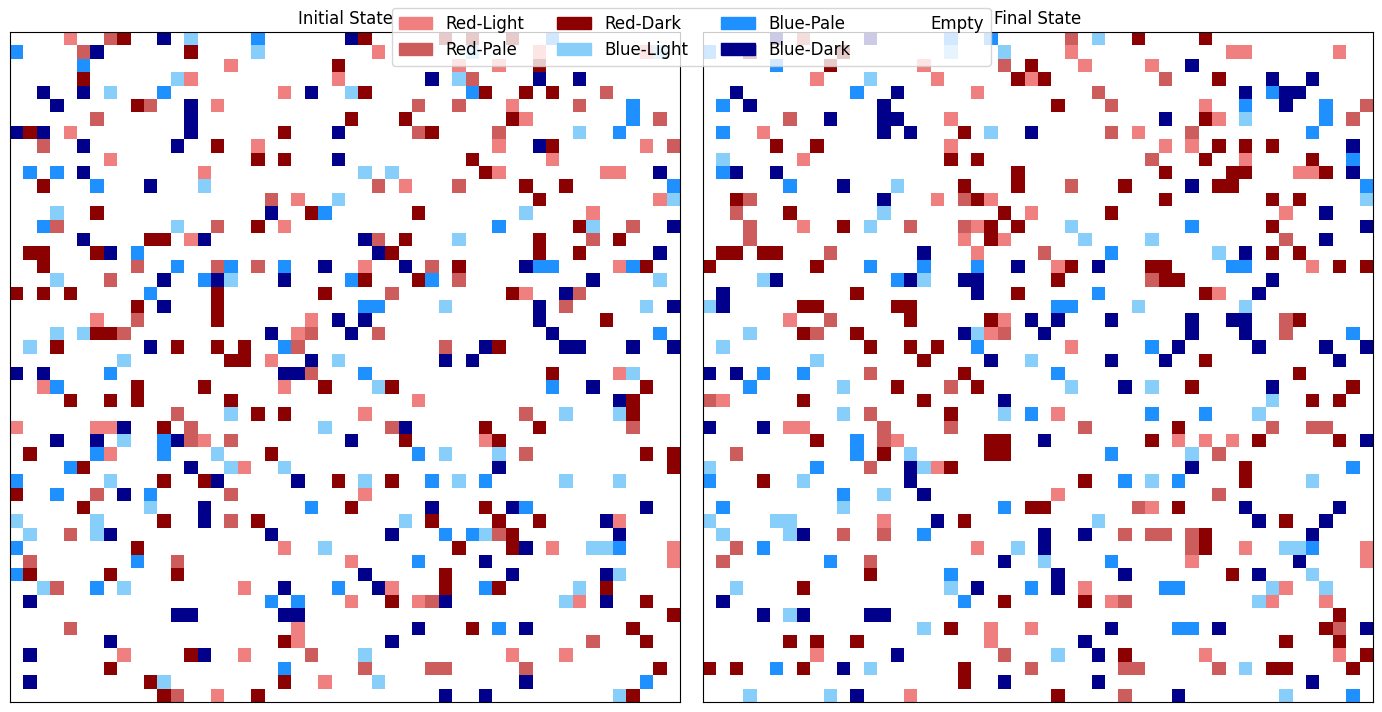

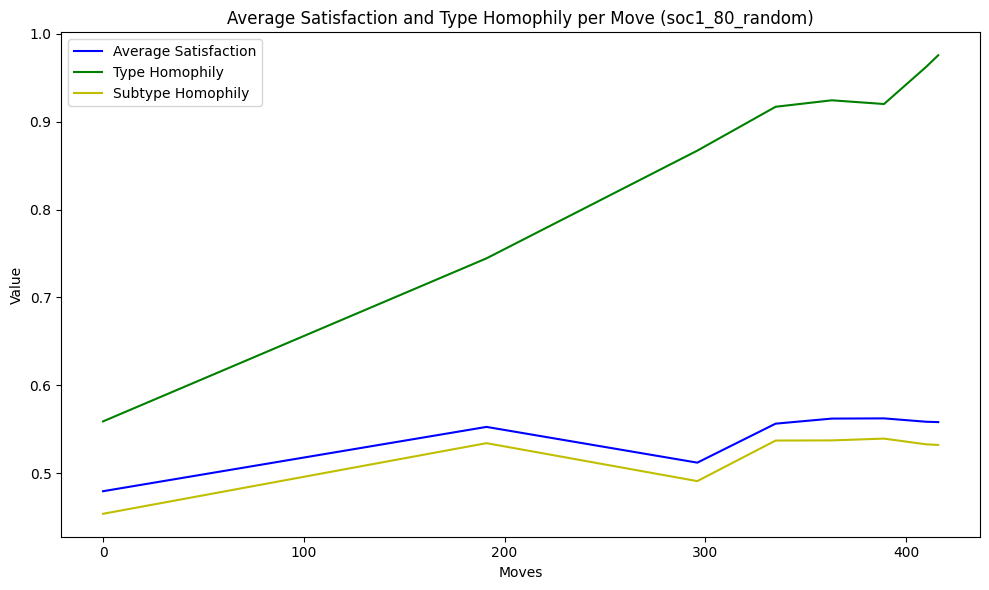

In [240]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="intolerant", relocation_strategy="random")

# Run the model until it reaches equilibrium or a maximum number of steps
step = 0
while model.running:
    model.step()
    step += 1

# Collect the data after the model has finished running
soc3_20_random_agent = model.datacollector.get_agent_vars_dataframe()
soc3_20_random_model = model.datacollector.get_model_vars_dataframe()

print(soc3_20_random_agent.head())
print(soc3_20_random_model.head())

plot_initial_final_states(soc3_20_random_agent)
metrics_graph(soc3_20_random_model)

Society = 3

Strategy = Move to a Random Cell with Higher Satisfaction

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (27, 43)       middle       Red         Dark   
     1        (46, 37)       middle       Red         Pale   
     2         (1, 10)       middle       Red         Dark   
     3         (7, 20)       middle       Red         Dark   
     4        (45, 15)       middle      Blue         Pale   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.25      0        NaN      0.571429   
     1                      0.50      0        NaN      0.142857   
     2                      0.25      0        NaN      0.200000   
     3                      0.25      0        NaN      0.666667   
     4                      0.50      0        NaN      0.000000   

              Type Homophily  Subtype H

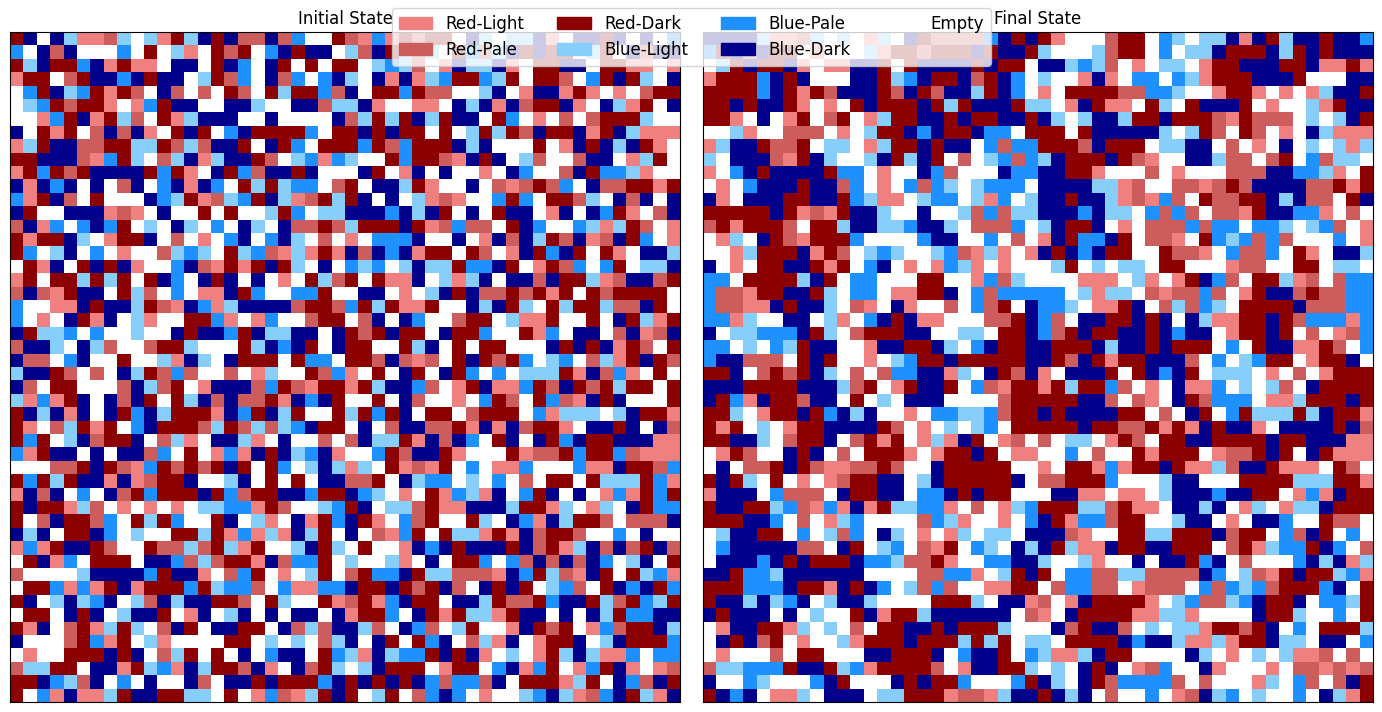

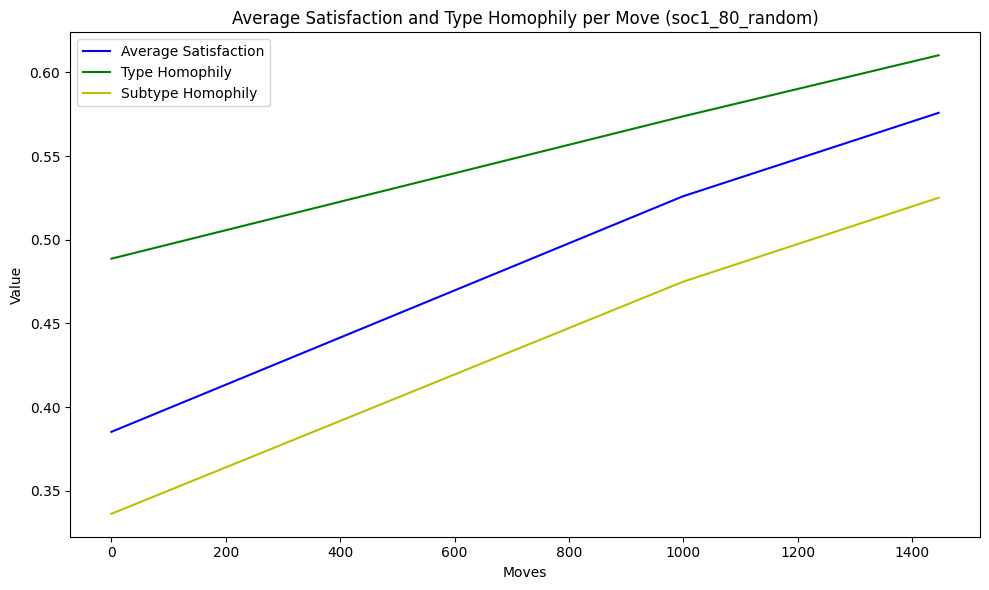

In [241]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="intolerant", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc3_80_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc3_80_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc3_80_random_hs_agent.head())
print(soc3_80_random_hs_model.head())

plot_initial_final_states(soc3_80_random_hs_agent)
metrics_graph(soc3_80_random_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (15, 11)       middle      Blue        Light   
     1        (30, 46)       middle      Blue         Pale   
     2         (26, 0)         edge       Red         Dark   
     3         (37, 1)       middle       Red         Pale   
     4         (8, 35)       middle      Blue         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN      1.000000   
     1                      0.50      0        NaN      0.333333   
     2                      0.25      0        NaN      0.750000   
     3                      0.50      0        NaN      0.400000   
     4                      0.25      0        NaN      1.000000   

              Type Homophily  Subtype H

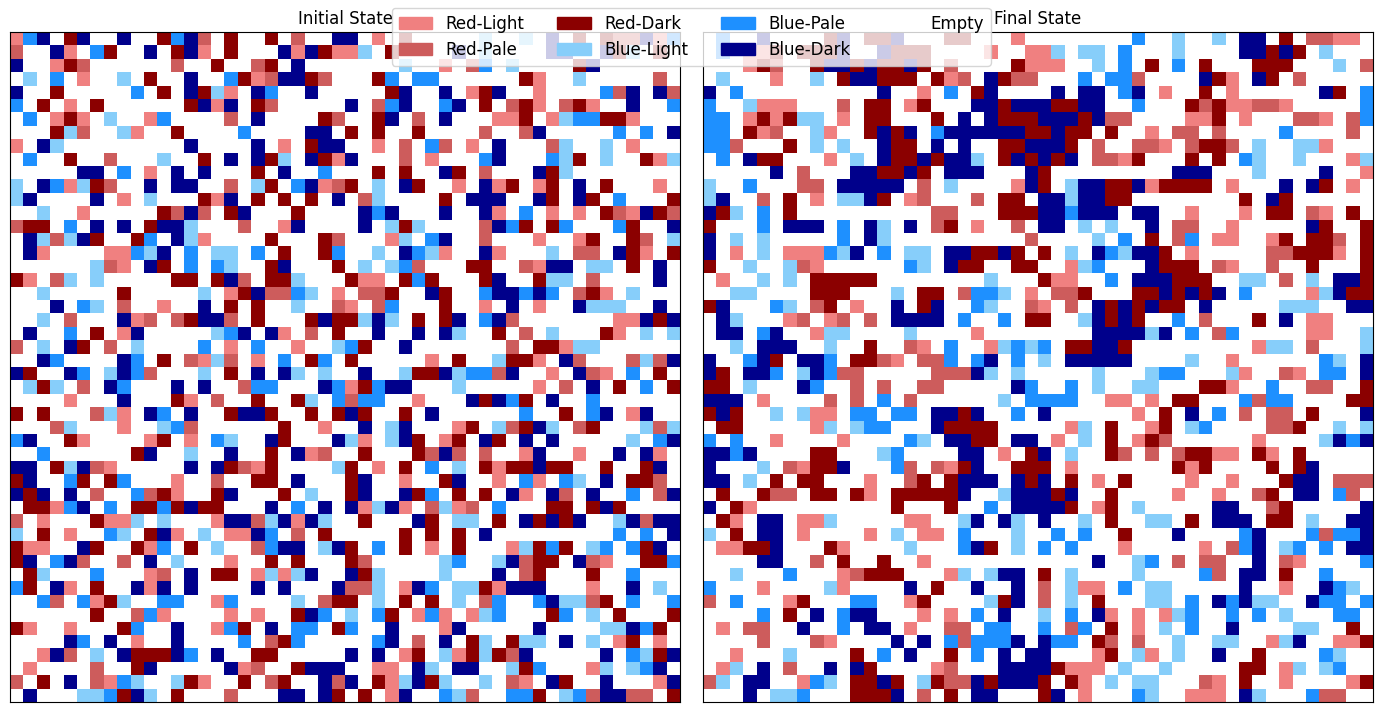

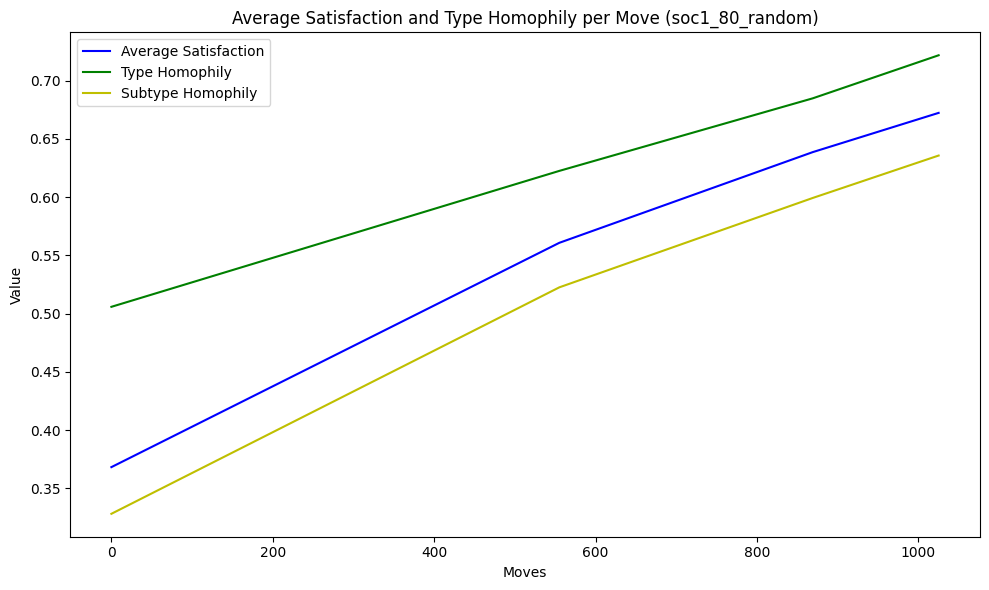

In [242]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="intolerant", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc3_50_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc3_50_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc3_50_random_hs_agent.head())
print(soc3_50_random_hs_model.head())

plot_initial_final_states(soc3_50_random_hs_agent)
metrics_graph(soc3_50_random_hs_model)

Equilibrium reached.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (44, 30)       middle      Blue         Pale   
     1        (23, 42)       middle      Blue         Dark   
     2          (8, 3)       middle       Red         Dark   
     3        (29, 29)       middle       Red         Dark   
     4         (3, 12)       middle      Blue         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.50      0        NaN      0.333333   
     1                      0.25      0        NaN      0.500000   
     2                      0.25      0        NaN      1.000000   
     3                      0.25      0        NaN      0.500000   
     4                      0.25      0        NaN      1.000000   

              Type Homophily  Subtype Homophily  
Step AgentID     

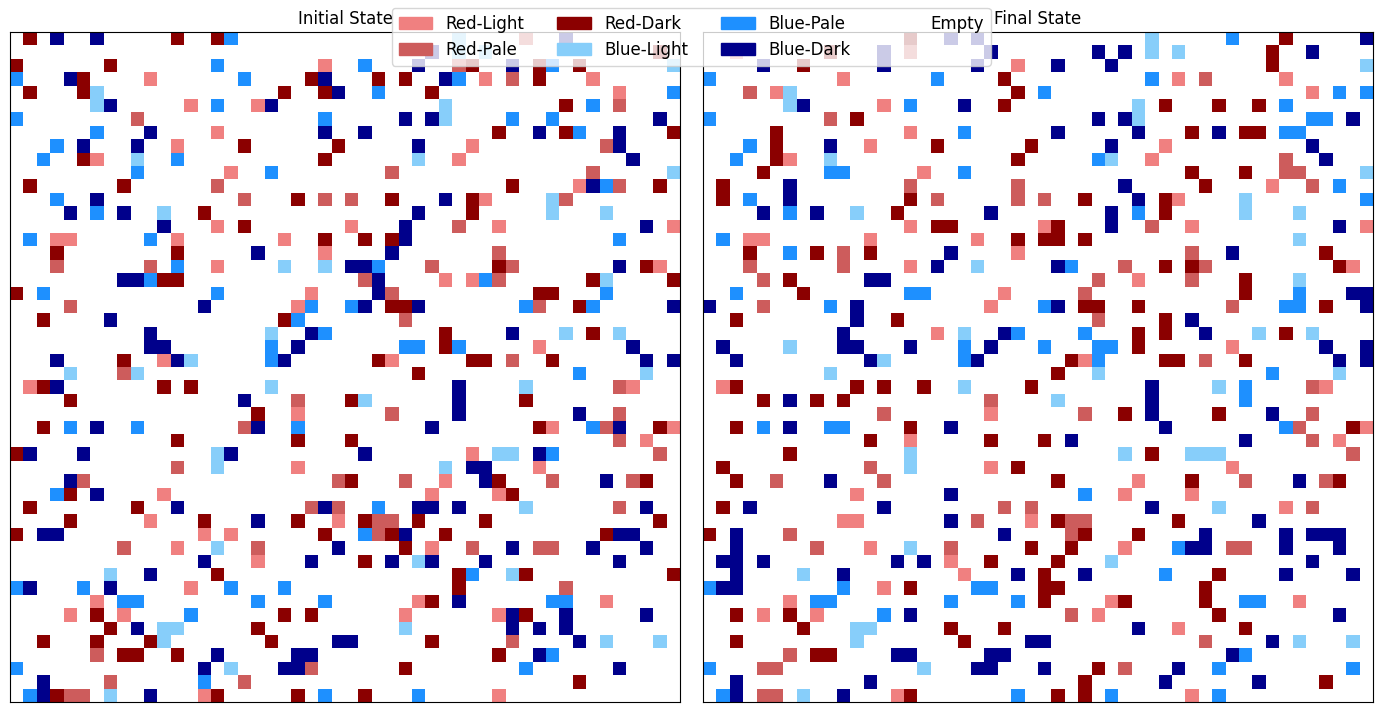

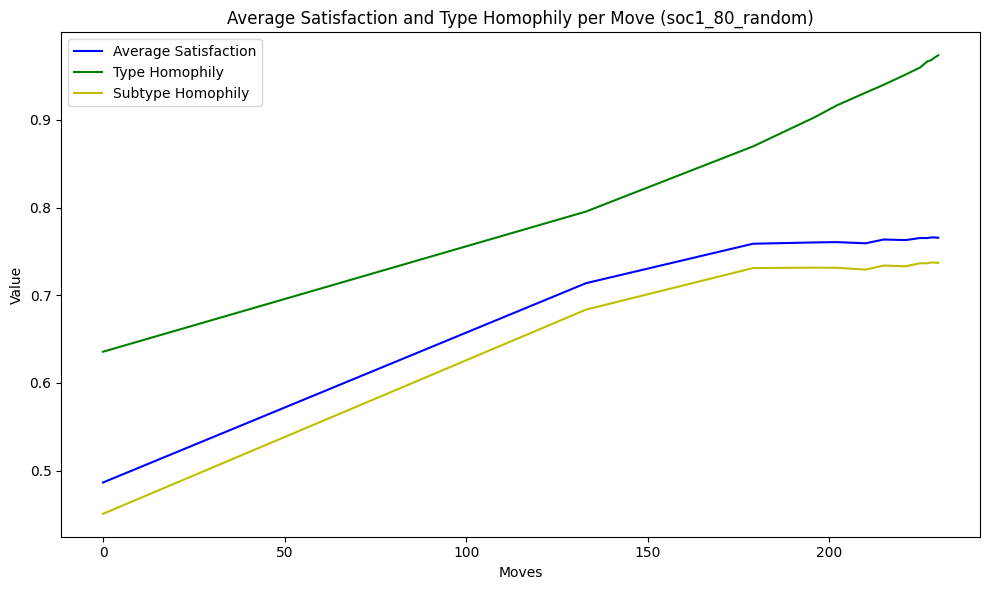

In [243]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="intolerant", relocation_strategy="random_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc3_20_random_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc3_20_random_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc3_20_random_hs_agent.head())
print(soc3_20_random_hs_model.head())

plot_initial_final_states(soc3_20_random_hs_agent)
metrics_graph(soc3_20_random_hs_model)

Society = 3

Relocation = Nearest highest satisfaction

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (37, 4)       middle       Red         Dark   
     1        (45, 49)         edge       Red         Dark   
     2        (38, 47)       middle       Red         Dark   
     3        (45, 13)       middle      Blue         Dark   
     4        (36, 11)       middle       Red         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.25      0        NaN      0.333333   
     1                      0.25      0        NaN      0.666667   
     2                      0.25      0        NaN      0.571429   
     3                      0.25      0        NaN      0.857143   
     4                      0.25      0        NaN      0.428571   

              Type Homophily  Subtype H

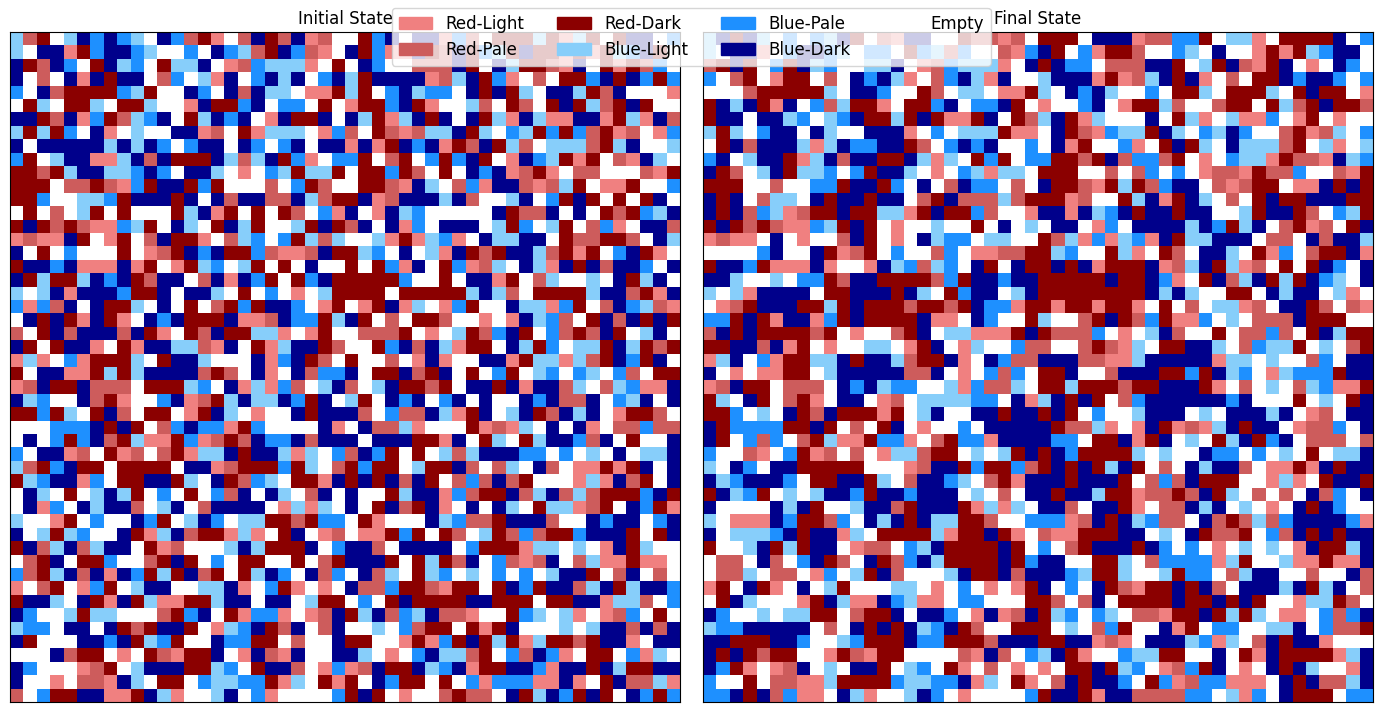

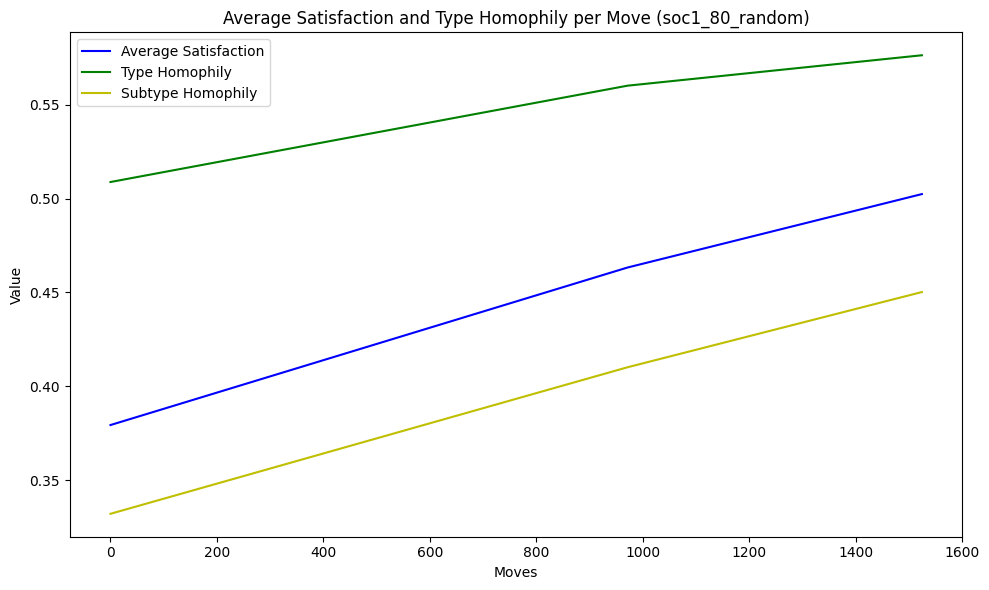

In [244]:
model = SchellingModel(width=50, height=50, density=0.8, society_type="intolerant", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc3_80_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc3_80_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc3_80_near_hs_agent.head())
print(soc3_80_near_hs_model.head())

plot_initial_final_states(soc3_80_near_hs_agent)
metrics_graph(soc3_80_near_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0        (43, 23)       middle       Red         Dark   
     1        (47, 10)       middle      Blue         Dark   
     2        (26, 31)       middle      Blue         Pale   
     3        (34, 27)       middle       Red        Light   
     4         (37, 5)       middle      Blue         Dark   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.25      0        NaN      0.600000   
     1                      0.25      0        NaN      1.000000   
     2                      0.50      0        NaN      0.500000   
     3                      0.75      0        NaN      0.000000   
     4                      0.25      0        NaN      0.666667   

              Type Homophily  Subtype H

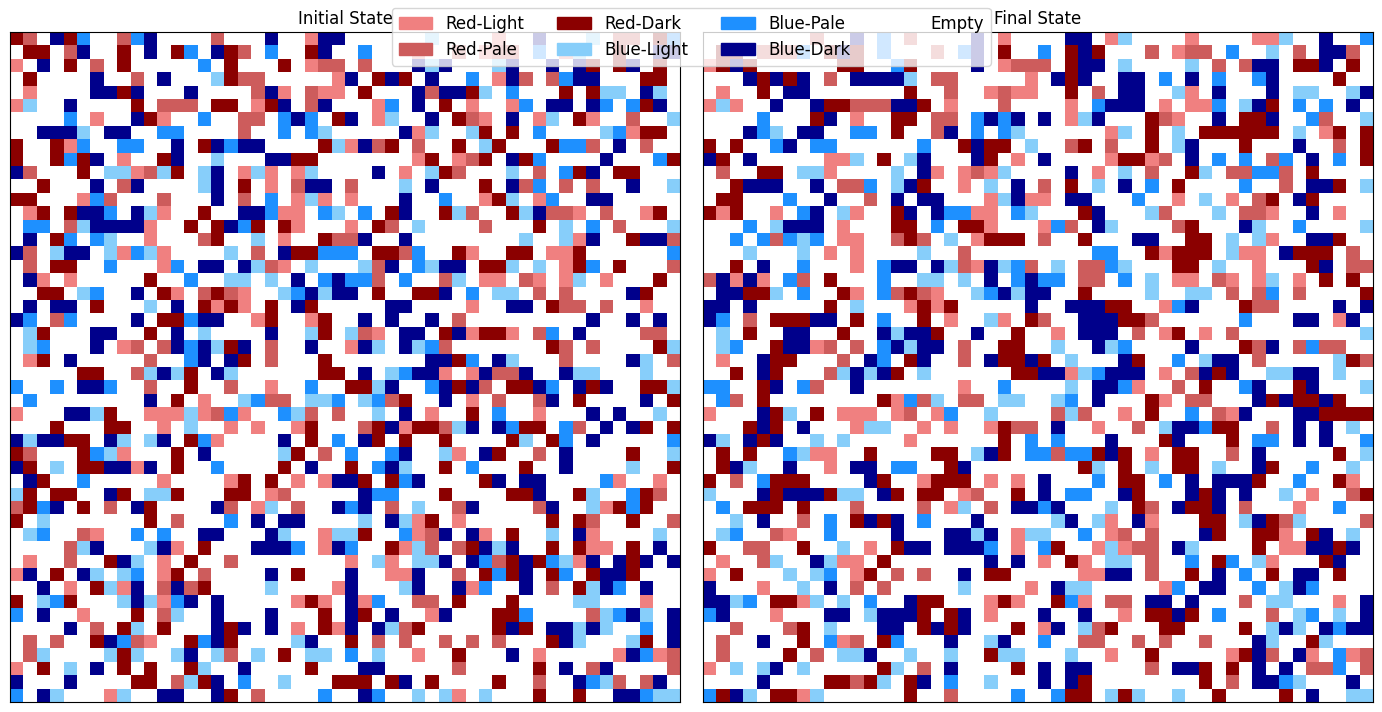

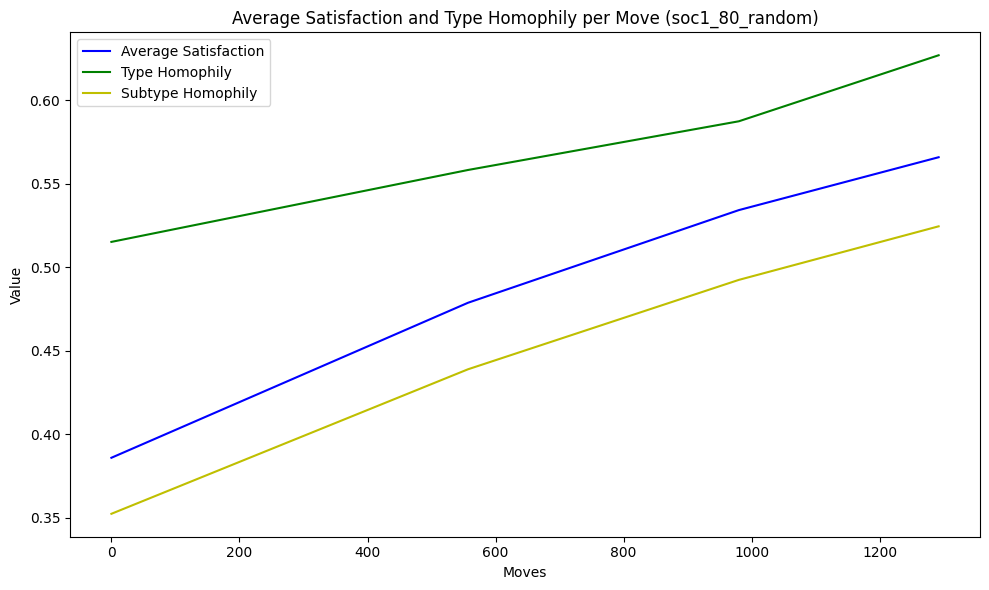

In [245]:
model = SchellingModel(width=50, height=50, density=0.5, society_type="intolerant", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc3_50_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc3_50_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc3_50_near_hs_agent.head())
print(soc3_50_near_hs_model.head())

plot_initial_final_states(soc3_50_near_hs_agent)
metrics_graph(soc3_50_near_hs_model)

Move limit of 1000 reached. Stopping simulation.
              Position PositionType AgentType AgentSubtype  \
Step AgentID                                                 
0    0         (19, 5)       middle       Red        Light   
     1        (37, 11)       middle      Blue        Light   
     2         (3, 45)       middle       Red         Dark   
     3         (15, 7)       middle      Blue         Pale   
     4         (9, 28)       middle       Red        Light   

              ToleranceThreshold  Moves  Diversity  Satisfaction  \
Step AgentID                                                       
0    0                      0.75      0        NaN      1.000000   
     1                      0.75      0        NaN      1.000000   
     2                      0.25      0        NaN      1.000000   
     3                      0.50      0        NaN      1.000000   
     4                      0.75      0        NaN      0.666667   

              Type Homophily  Subtype H

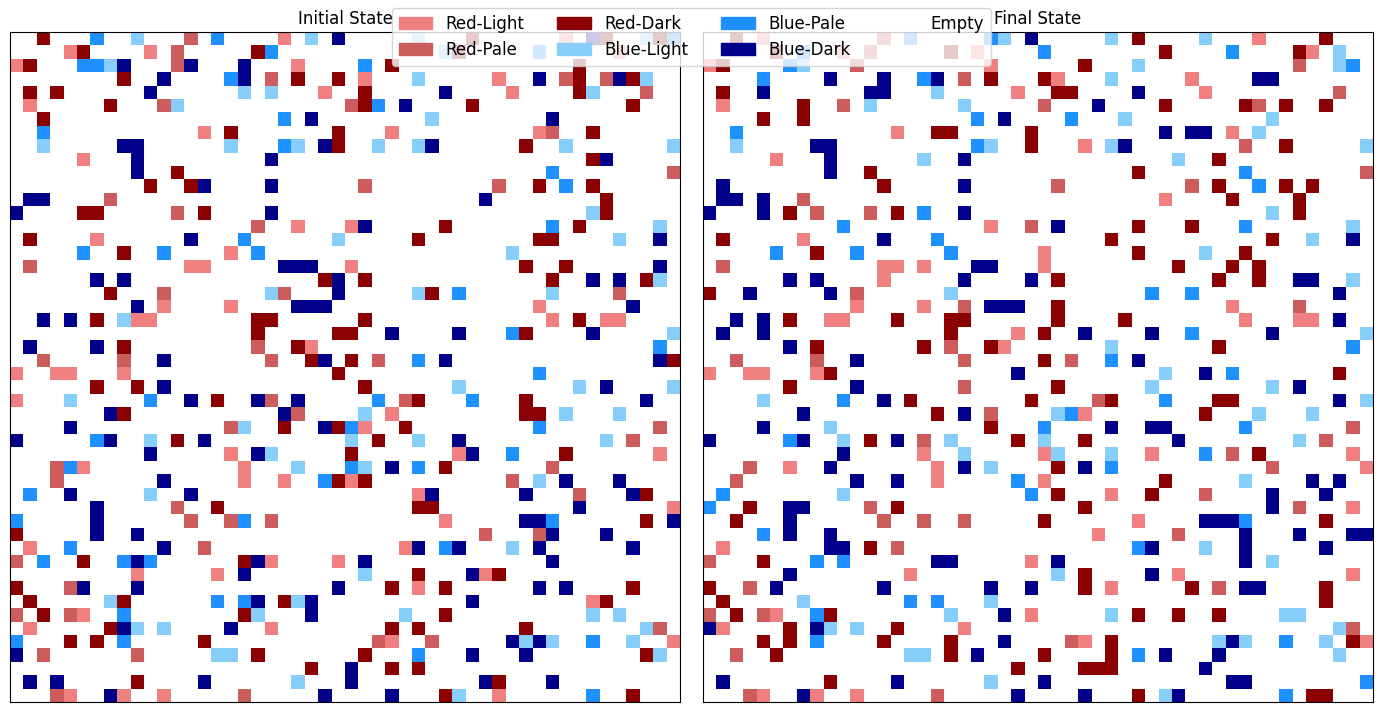

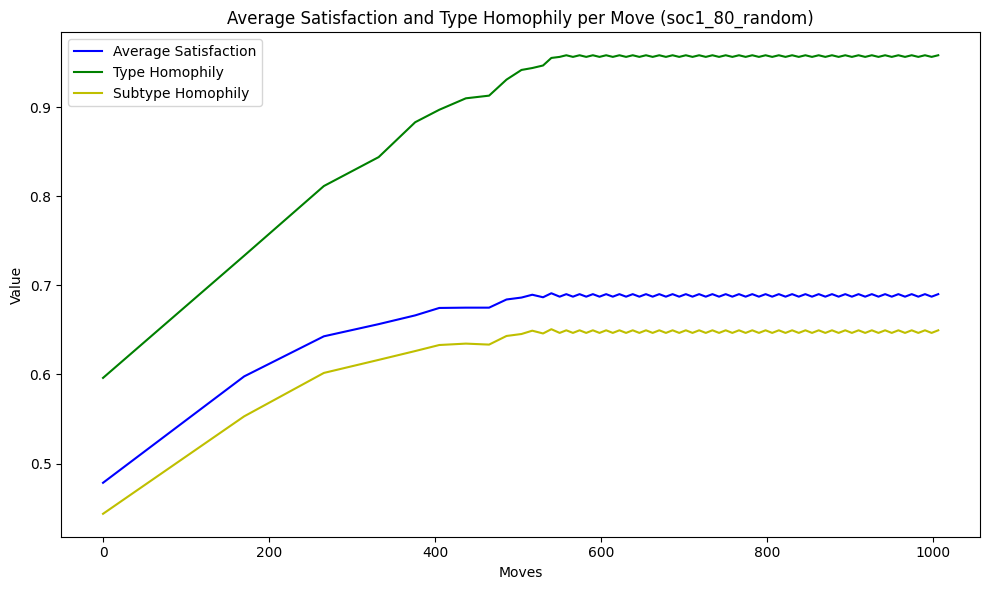

In [246]:
model = SchellingModel(width=50, height=50, density=0.2, society_type="intolerant", relocation_strategy="nearest_higher_satisfaction")

# Run the model until it reaches equilibrium or a maximum number of steps
while model.running:
    model.step()

# Collect the data after the model has finished running
soc3_20_near_hs_agent = model.datacollector.get_agent_vars_dataframe()
soc3_20_near_hs_model = model.datacollector.get_model_vars_dataframe()

print(soc3_20_near_hs_agent.head())
print(soc3_20_near_hs_model.head())

plot_initial_final_states(soc3_20_near_hs_agent)
metrics_graph(soc3_20_near_hs_model)

## Perform Analysis

Here we perform our Satisfaction, Homophily (Diversity) and Corner and Edge analysis

Satisfaction Analysis

In [265]:
# Make a function to compute the average satisfaction, homophily, and diversity
def compute_metrics(model_data):
    avg_satisfaction = model_data['Average Satisfaction'].mean()
    avg_type_homophily = model_data['Type Homophily'].mean()
    avg_subtype_homophily = model_data['Subtype Homophily'].mean()

    # Compute the diversity as 1 - homophily
    avg_type_diversity = 1 - avg_type_homophily
    avg_subtype_diversity = 1 - avg_subtype_homophily

    # Get the first and last step satisfaction, homophily and diversity
    first_satisfaction = model_data['Average Satisfaction'].iloc[0]
    last_satisfaction = model_data['Average Satisfaction'].iloc[-1]

    first_type_homophily = model_data['Type Homophily'].iloc[0]
    last_type_homophily = model_data['Type Homophily'].iloc[-1]

    first_type_diversity =  1 - first_type_homophily 
    last_type_diversity = 1 - last_type_homophily

    first_subtype_homophily = model_data['Subtype Homophily'].iloc[0]
    last_subtype_homophily = model_data['Subtype Homophily'].iloc[-1]

    first_subtype_diversity =  1 - first_subtype_homophily 
    last_subtype_diversity = 1 - last_subtype_homophily

    return (avg_satisfaction, first_satisfaction, last_satisfaction,
            avg_type_homophily, first_type_homophily, last_type_homophily,
            avg_subtype_homophily, first_subtype_homophily, last_subtype_homophily, 
            avg_type_diversity, avg_subtype_diversity, first_type_diversity, last_type_diversity,
            first_subtype_diversity, last_subtype_diversity)

# Initialize lists to store the data
model_names = []
societies = []
densities = []
strategies = []
avg_satisfactions = []
first_satisfactions = []
last_satisfactions = []
avg_type_homophilies = []
first_type_homophilies = []
last_type_homophilies = []
avg_subtype_homophilies = []
first_subtype_homophilies = []
last_subtype_homophilies = []
avg_type_diversities = []
first_type_diversities = []
last_type_diversities = []
avg_subtype_diversities = []
first_subtype_diversities = []
last_subtype_diversities = []


# List of models to iterate through
models = [
# Society 1 
    ('soc1_80_random_model', 'Tolerant', 0.8, 'Random', soc1_80_random_model),
    ('soc1_50_random_model', 'Tolerant', 0.5, 'Random', soc1_50_random_model),
    ('soc1_20_random_model', 'Tolerant', 0.2, 'Random', soc1_20_random_model),
    
    ('soc1_80_random_hs_model', 'Tolerant', 0.8, 'Higher Satisfaction', soc1_80_random_hs_model),
    ('soc1_50_random_hs_model', 'Tolerant', 0.5, 'Higher Satisfaction', soc1_50_random_hs_model),
    ('soc1_20_random_hs_model', 'Tolerant', 0.2, 'Higher Satisfaction', soc1_20_random_hs_model),
    
    ('soc1_80_near_hs_model', 'Tolerant', 0.8, 'Nearest Higher Satisfaction', soc1_80_near_hs_model),
    ('soc1_50_near_hs_model', 'Tolerant', 0.5, 'Nearest Higher Satisfaction', soc1_50_near_hs_model),
    ('soc1_20_near_hs_model', 'Tolerant', 0.2, 'Nearest Higher Satisfaction', soc1_20_near_hs_model),

    # Society 2 
    ('soc2_80_random_model', 'Neutral', 0.8, 'Random', soc2_80_random_model),
    ('soc2_50_random_model', 'Neutral', 0.5, 'Random', soc2_50_random_model),
    ('soc2_20_random_model', 'Neutral', 0.2, 'Random', soc2_20_random_model),
    
    ('soc2_80_random_hs_model', 'Neutral', 0.8, 'Higher Satisfaction', soc2_80_random_hs_model),
    ('soc2_50_random_hs_model', 'Neutral', 0.5, 'Higher Satisfaction', soc2_50_random_hs_model),
    ('soc2_20_random_hs_model', 'Neutral', 0.2, 'Higher Satisfaction', soc2_20_random_hs_model),
    
    ('soc2_80_near_hs_model', 'Neutral', 0.8, 'Nearest Higher Satisfaction', soc2_80_near_hs_model),
    ('soc2_50_near_hs_model', 'Neutral', 0.5, 'Nearest Higher Satisfaction', soc2_50_near_hs_model),
    ('soc2_20_near_hs_model', 'Neutral', 0.2, 'Nearest Higher Satisfaction', soc2_20_near_hs_model),

    # Society 3
    ('soc3_80_random_model', 'Intolerant', 0.8, 'Random', soc3_80_random_model),
    ('soc3_50_random_model', 'Intolerant', 0.5, 'Random', soc3_50_random_model),
    ('soc3_20_random_model', 'Intolerant', 0.2, 'Random', soc3_20_random_model),
    
    ('soc3_80_random_hs_model', 'Intolerant', 0.8, 'Higher Satisfaction', soc3_80_random_hs_model),
    ('soc3_50_random_hs_model', 'Intolerant', 0.5, 'Higher Satisfaction', soc3_50_random_hs_model),
    ('soc3_20_random_hs_model', 'Intolerant', 0.2, 'Higher Satisfaction', soc3_20_random_hs_model),
    
    ('soc3_80_near_hs_model', 'Intolerant', 0.8, 'Nearest Higher Satisfaction', soc3_80_near_hs_model),
    ('soc3_50_near_hs_model', 'Intolerant', 0.5, 'Nearest Higher Satisfaction', soc3_50_near_hs_model),
    ('soc3_20_near_hs_model', 'Intolerant', 0.2, 'Nearest Higher Satisfaction', soc3_20_near_hs_model)
]

# Loop through the models and collect metrics
for model_name, society, density, strategy, model_data in models:
    (avg_satisfaction, first_satisfaction, last_satisfaction,
     avg_type_homophily, first_type_homophily, last_type_homophily,
     avg_subtype_homophily, first_subtype_homophily, last_subtype_homophily,
     avg_type_diversity, avg_subtype_diversity, first_type_diversity, last_type_diversity,
    first_subtype_diversity, last_subtype_diversity) = compute_metrics(model_data)
    
    model_names.append(model_name)
    societies.append(society)
    densities.append(density)
    strategies.append(strategy)
    avg_satisfactions.append(avg_satisfaction)
    first_satisfactions.append(first_satisfaction)
    last_satisfactions.append(last_satisfaction)
    avg_type_homophilies.append(avg_type_homophily)
    first_type_homophilies.append(first_type_homophily)
    last_type_homophilies.append(last_type_homophily)
    avg_subtype_homophilies.append(avg_subtype_homophily)
    first_subtype_homophilies.append(first_subtype_homophily)
    last_subtype_homophilies.append(last_subtype_homophily)
    avg_type_diversities.append(avg_type_diversity)
    first_type_diversities.append(first_type_diversity)
    last_type_diversities.append(last_type_diversity)
    avg_subtype_diversities.append(avg_subtype_diversity)
    first_subtype_diversities.append(first_subtype_diversity)
    last_subtype_diversities.append(last_subtype_diversity)

model_data = pd.DataFrame({
    "Model Name": model_names,
    "Society": societies,
    "Density": densities,
    "Movement Method": strategies,
    "Average Satisfaction": avg_satisfactions,
    "First Satisfaction": first_satisfactions,
    "Last Satisfaction": last_satisfactions,
    "Average Type Homophily": avg_type_homophilies,
    "First Type Homophily": first_type_homophilies,
    "Last Type Homophily": last_type_homophilies,
    "Average Subtype Homophily": avg_subtype_homophilies,
    "First Subtype Homophily": first_subtype_homophilies,
    "Last Subtype Homophily": last_subtype_homophilies,
    "Average Type Diversity": avg_type_diversities,
    "First Type Diversity": first_type_diversities,
    "Last Type Diversity": last_type_diversities,
    "Average Subtype Diversity": avg_subtype_diversities,
    "First Subtype Diversity": first_subtype_diversities,
    "Last Subtype Diversity": last_subtype_diversities
})

In [266]:
model_data.head()

,Model Name,Society,Density,Movement Method,Average Satisfaction,First Satisfaction,Last Satisfaction,Average Type Homophily,First Type Homophily,Last Type Homophily,Average Subtype Homophily,First Subtype Homophily,Last Subtype Homophily,Average Type Diversity,First Type Diversity,Last Type Diversity,Average Subtype Diversity,First Subtype Diversity,Last Subtype Diversity
0,soc1_80_random_model,Tolerant,0.8,Random,0.366089,0.364054,0.367530,0.591326,0.508769,0.655230,0.329368,0.327398,0.330265,0.408674,0.491231,0.344770,0.670632,0.672602,0.669735
1,soc1_50_random_model,Tolerant,0.5,Random,0.391462,0.395212,0.389478,0.658763,0.499879,0.768680,0.341497,0.348436,0.337273,0.341237,0.500121,0.231320,0.658503,0.651564,0.662727
2,soc1_20_random_model,Tolerant,0.2,Random,0.466946,0.435333,0.469000,0.893140,0.579510,0.980834,0.437789,0.404761,0.440693,0.106860,0.420490,0.019166,0.562211,0.595239,0.559307
3,soc1_80_random_hs_model,Tolerant,0.8,Higher Satisfaction,0.453741,0.363386,0.518761,0.584130,0.509163,0.645824,0.432110,0.330483,0.505495,0.415870,0.490837,0.354176,0.567890,0.669517,0.494505
4,soc1_50_random_hs_model,Tolerant,0.5,Higher Satisfaction,0.645669,0.392918,0.685364,0.728518,0.490666,0.782680,0.627482,0.349928,0.671571,0.271482,0.509334,0.217320,0.372518,0.650072,0.328429


Society, Movement Method and Density with Satisfaction

In [249]:
society_satisfaction = model_data.groupby("Society")["First Satisfaction"].mean()

print(society_satisfaction)

society_satisfaction = model_data.groupby("Society")["Last Satisfaction"].mean()

print(society_satisfaction)

society_satisfaction = model_data.groupby("Society")["Average Satisfaction"].mean()

print(society_satisfaction)


Society
Intolerant    0.413451
Neutral       0.418464
Tolerant      0.399041
Name: First Satisfaction, dtype: float64
Society
Intolerant    0.567832
Neutral       0.550860
Tolerant      0.525748
Name: Last Satisfaction, dtype: float64
Society
Intolerant    0.524870
Neutral       0.522696
Tolerant      0.496642
Name: Average Satisfaction, dtype: float64


In [264]:
mm_satisfaction = model_data.groupby("Movement Method")["First Satisfaction"].mean()

print(mm_satisfaction)

mm_satisfaction = model_data.groupby("Movement Method")["Last Satisfaction"].mean()

print(mm_satisfaction)

mm_satisfaction = model_data.groupby("Movement Method")["Average Satisfaction"].mean()

print(mm_satisfaction)

Movement Method
Higher Satisfaction            0.408221
Nearest Higher Satisfaction    0.411015
Random                         0.411720
Name: First Satisfaction, dtype: float64
Movement Method
Higher Satisfaction            0.657332
Nearest Higher Satisfaction    0.557723
Random                         0.429385
Name: Last Satisfaction, dtype: float64
Movement Method
Higher Satisfaction            0.601008
Nearest Higher Satisfaction    0.517547
Random                         0.425654
Name: Average Satisfaction, dtype: float64


In [250]:
density_satisfaction = model_data.groupby("Density")["First Satisfaction"].mean()

print(density_satisfaction)

density_satisfaction = model_data.groupby("Density")["Last Satisfaction"].mean()

print(density_satisfaction)

density_satisfaction = model_data.groupby("Density")["Average Satisfaction"].mean()

print(density_satisfaction)


Density
0.2    0.473374
0.5    0.383130
0.8    0.374452
Name: First Satisfaction, dtype: float64
Density
0.2    0.638544
0.5    0.533480
0.8    0.472416
Name: Last Satisfaction, dtype: float64
Density
0.2    0.623669
0.5    0.489650
0.8    0.430891
Name: Average Satisfaction, dtype: float64


Society and Density with Type Homophily and Diversity

Note: In my report I used the "Diversity" analysis for Homophily, since the definition I used for Homophily is the complement of Diversity, which is being used as the definition for Homophily in this case, according to the Moodle page.

In [251]:
society_t_homophily = model_data.groupby("Society")["First Type Homophily"].mean()

print(society_t_homophily)

society_t_homophily  = model_data.groupby("Society")["Last Type Homophily"].mean()

print(society_t_homophily )

society_t_homophily  = model_data.groupby("Society")["Average Type Homophily"].mean()

print(society_t_homophily)

Society
Intolerant    0.533057
Neutral       0.527089
Tolerant      0.528458
Name: First Type Homophily, dtype: float64
Society
Intolerant    0.748292
Neutral       0.779774
Tolerant      0.761962
Name: Last Type Homophily, dtype: float64
Society
Intolerant    0.687463
Neutral       0.718568
Tolerant      0.697676
Name: Average Type Homophily, dtype: float64


In [267]:
society_t_diversity = model_data.groupby("Society")["First Type Diversity"].mean()

print(society_t_diversity)

society_t_diversity  = model_data.groupby("Society")["Last Type Diversity"].mean()

print(society_t_diversity)

society_t_diversity  = model_data.groupby("Society")["Average Type Diversity"].mean()

print(society_t_diversity)

Society
Intolerant    0.466943
Neutral       0.472911
Tolerant      0.471542
Name: First Type Diversity, dtype: float64
Society
Intolerant    0.251708
Neutral       0.220226
Tolerant      0.238038
Name: Last Type Diversity, dtype: float64
Society
Intolerant    0.312537
Neutral       0.281432
Tolerant      0.302324
Name: Average Type Diversity, dtype: float64


In [268]:
mm_homophily = model_data.groupby("Movement Method")["First Type Homophily"].mean()

print(mm_homophily)

mm_homophily = model_data.groupby("Movement Method")["Last Type Homophily"].mean()

print(mm_homophily)

mm_homophily = model_data.groupby("Movement Method")["Average Type Homophily"].mean()

print(mm_homophily)

Movement Method
Higher Satisfaction            0.528958
Nearest Higher Satisfaction    0.534602
Random                         0.525043
Name: First Type Homophily, dtype: float64
Movement Method
Higher Satisfaction            0.785637
Nearest Higher Satisfaction    0.712504
Random                         0.791887
Name: Last Type Homophily, dtype: float64
Movement Method
Higher Satisfaction            0.718263
Nearest Higher Satisfaction    0.677232
Random                         0.708213
Name: Average Type Homophily, dtype: float64


In [270]:
mm_diversity = model_data.groupby("Movement Method")["First Type Diversity"].mean()

print(mm_diversity)

mm_diversity = model_data.groupby("Movement Method")["Last Type Diversity"].mean()

print(mm_diversity)

mm_diversity = model_data.groupby("Movement Method")["Average Type Diversity"].mean()

print(mm_diversity)

Movement Method
Higher Satisfaction            0.471042
Nearest Higher Satisfaction    0.465398
Random                         0.474957
Name: First Type Diversity, dtype: float64
Movement Method
Higher Satisfaction            0.214363
Nearest Higher Satisfaction    0.287496
Random                         0.208113
Name: Last Type Diversity, dtype: float64
Movement Method
Higher Satisfaction            0.281737
Nearest Higher Satisfaction    0.322768
Random                         0.291787
Name: Average Type Diversity, dtype: float64


In [252]:
density_t_homophily = model_data.groupby("Density")["First Type Homophily"].mean()

print(density_t_homophily)

density_t_homophily  = model_data.groupby("Density")["Last Type Homophily"].mean()

print(density_t_homophily )

density_t_homophily  = model_data.groupby("Density")["Average Type Homophily"].mean()

print(density_t_homophily)

Density
0.2    0.583528
0.5    0.503525
0.8    0.501551
Name: First Type Homophily, dtype: float64
Density
0.2    0.949407
0.5    0.721109
0.8    0.619512
Name: Last Type Homophily, dtype: float64
Density
0.2    0.890168
0.5    0.646978
0.8    0.566562
Name: Average Type Homophily, dtype: float64


In [271]:
density_t_d = model_data.groupby("Density")["First Type Diversity"].mean()

print(density_t_d)

density_t_d  = model_data.groupby("Density")["Last Type Diversity"].mean()

print(density_t_d)

density_t_d  = model_data.groupby("Density")["Average Type Diversity"].mean()

print(density_t_d)

Density
0.2    0.416472
0.5    0.496475
0.8    0.498449
Name: First Type Diversity, dtype: float64
Density
0.2    0.050593
0.5    0.278891
0.8    0.380488
Name: Last Type Diversity, dtype: float64
Density
0.2    0.109832
0.5    0.353022
0.8    0.433438
Name: Average Type Diversity, dtype: float64


Society and Density with Subtype Homophily

In [253]:
society_st_homophily = model_data.groupby("Society")["First Subtype Homophily"].mean()

print(society_st_homophily)

society_st_homophily  = model_data.groupby("Society")["Last Subtype Homophily"].mean()

print(society_st_homophily )

society_st_homophily  = model_data.groupby("Society")["Average Subtype Homophily"].mean()

print(society_st_homophily)

Society
Intolerant    0.373194
Neutral       0.378745
Tolerant      0.366323
Name: First Subtype Homophily, dtype: float64
Society
Intolerant    0.526283
Neutral       0.519554
Tolerant      0.502519
Name: Last Subtype Homophily, dtype: float64
Society
Intolerant    0.483947
Neutral       0.489791
Tolerant      0.470821
Name: Average Subtype Homophily, dtype: float64


In [272]:
society_st_diversity = model_data.groupby("Society")["First Subtype Diversity"].mean()

print(society_st_diversity)

society_st_diversity  = model_data.groupby("Society")["Last Subtype Diversity"].mean()

print(society_st_diversity)

society_st_diversity  = model_data.groupby("Society")["Average Subtype Diversity"].mean()

print(society_st_diversity)

Society
Intolerant    0.626806
Neutral       0.621255
Tolerant      0.633677
Name: First Subtype Diversity, dtype: float64
Society
Intolerant    0.473717
Neutral       0.480446
Tolerant      0.497481
Name: Last Subtype Diversity, dtype: float64
Society
Intolerant    0.516053
Neutral       0.510209
Tolerant      0.529179
Name: Average Subtype Diversity, dtype: float64


In [273]:
mm_diversity = model_data.groupby("Movement Method")["First Subtype Diversity"].mean()

print(mm_diversity)

mm_diversity = model_data.groupby("Movement Method")["Last Subtype Diversity"].mean()

print(mm_diversity)

mm_diversity = model_data.groupby("Movement Method")["Average Subtype Diversity"].mean()

print(mm_diversity)

Movement Method
Higher Satisfaction            0.628328
Nearest Higher Satisfaction    0.624449
Random                         0.628961
Name: First Subtype Diversity, dtype: float64
Movement Method
Higher Satisfaction            0.367251
Nearest Higher Satisfaction    0.474489
Random                         0.609904
Name: Last Subtype Diversity, dtype: float64
Movement Method
Higher Satisfaction            0.426179
Nearest Higher Satisfaction    0.515795
Random                         0.613468
Name: Average Subtype Diversity, dtype: float64


In [254]:
density_st_homophily = model_data.groupby("Density")["First Subtype Homophily"].mean()

print(density_st_homophily)

density_st_homophily  = model_data.groupby("Density")["Last Subtype Homophily"].mean()

print(density_st_homophily )

density_st_homophily  = model_data.groupby("Density")["Average Subtype Homophily"].mean()

print(density_st_homophily)

Density
0.2    0.443022
0.5    0.341651
0.8    0.333590
Name: First Subtype Homophily, dtype: float64
Density
0.2    0.614011
0.5    0.498841
0.8    0.435504
Name: Last Subtype Homophily, dtype: float64
Density
0.2    0.598707
0.5    0.453676
0.8    0.392176
Name: Average Subtype Homophily, dtype: float64


In [274]:
density_s_d = model_data.groupby("Density")["First Subtype Diversity"].mean()

print(density_s_d)

density_s_d  = model_data.groupby("Density")["Last Subtype Diversity"].mean()

print(density_s_d)

density_s_d  = model_data.groupby("Density")["Average Subtype Diversity"].mean()

print(density_s_d)

Density
0.2    0.556978
0.5    0.658349
0.8    0.666410
Name: First Subtype Diversity, dtype: float64
Density
0.2    0.385989
0.5    0.501159
0.8    0.564496
Name: Last Subtype Diversity, dtype: float64
Density
0.2    0.401293
0.5    0.546324
0.8    0.607824
Name: Average Subtype Diversity, dtype: float64


Corner and Edge Case Analysis

In [279]:
agent_data = pd.concat([soc1_80_random_agent,
    soc1_50_random_agent,
    soc1_20_random_agent,
    soc1_80_random_hs_agent,
    soc1_50_random_hs_agent,
    soc1_20_random_hs_agent,
    soc1_80_near_hs_agent,
    soc1_50_near_hs_agent,
    soc1_20_near_hs_agent,
    
    soc2_80_random_agent,
    soc2_50_random_agent,
    soc2_20_random_agent,
    soc2_80_random_hs_agent,
    soc2_50_random_hs_agent,
    soc2_20_random_hs_agent,
    soc2_80_near_hs_agent,
    soc2_50_near_hs_agent,
    soc2_20_near_hs_agent,
    
    soc3_80_random_agent,
    soc3_50_random_agent,
    soc3_20_random_agent,
    soc3_80_random_hs_agent,
    soc3_50_random_hs_agent,
    soc3_20_random_hs_agent,
    soc3_80_near_hs_agent,
    soc3_50_near_hs_agent,
    soc3_20_near_hs_agent])

In [282]:
# Group by position type and calculate average metrics
position_metrics = agent_data.groupby("PositionType").agg({
    "Satisfaction": ["mean"],
    "Type Homophily": ["mean"],
    "Subtype Homophily": ["mean"]
}).reset_index()

# Calculate Diversity as the complement of Homophily, and use that for Homophily in report.
def calculate_diversity(homophily_column):
    return 1 - homophily_column

position_metrics['Type Diversity'] = 1 - position_metrics[('Type Homophily', 'mean')]
position_metrics['Subtype Diversity'] = 1 - position_metrics[('Subtype Homophily', 'mean')]

position_metrics



,PositionType,Satisfaction,Type Homophily,Subtype Homophily,Type Diversity,Subtype Diversity
,,mean,mean,mean,,
0,corner,0.610263,0.668244,0.479935,0.331756,0.520065
1,edge,0.553474,0.760585,0.532874,0.239415,0.467126
2,middle,0.564677,0.761445,0.532367,0.238555,0.467633
